# 1. Setup Environment, Define Functions and Preprocess Data

##  1.1 Import libraries and set settings

In [ ]:
# essentials
import pandas as pd
import numpy as np

# stat analysis
import statistics as st
from scipy import stats
from scipy.stats import skew
from scipy.stats import randint
from scipy.spatial.distance import cdist

# predictive modelling
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import export_graphviz
import statsmodels.api as sm

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

# Other
import warnings

In [ ]:
# suppress all warning notifications
warnings.filterwarnings('ignore')

In [ ]:
# disable scientific notation
np.set_printoptions(suppress=True)

# display all numeric values in the DataFrame in standard numeric format
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# set theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom":True}
sns.set_theme(style="white", rc=custom_params)

## 1.2 User-defined functions

In [ ]:
def extract_precision(report):
    """
    Extracts precision values from a classification report.

    This function takes a classification report dictionary and returns a new dictionary
    containing only the precision values for specific labels ('-1', '0', '1', 'macro avg', 'weighted avg').

    Parameters:
    report (dict): A dictionary representing the classification report, where keys are class labels
                   or summary statistics and values are dictionaries containing precision scores.

    Returns:
    dict: A dictionary mapping the selected labels to their corresponding precision values.
    """
    precision_dict = {}
    for k, v in report.items():
        if k in ['-1', '0', '1', 'macro avg', 'weighted avg']:
            precision_dict[k] = v["precision"]
    return precision_dict

In [ ]:
def calculate_strategy_returns(df, traded_signals, hold_days, return_col, signal_col):
    """
    Computes trade return, cumulative return, annualised cumulative return, and drawdown based on a given strategy.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing trade signals and returns.
    traded_signals (list): List of trade signals to consider.
    hold_days (int): Number of days each trade is held. Must match the window length of the specified return_col.
    return_col (str): Column name containing return values.
    signal_col (str): Column name containing trade signals.

    Returns:
    pd.DataFrame: Updated DataFrame with calculated returns.
    """

    df = df.sort_values(by=['date'], ascending=True)
    df['correct_signal'] = df['signal'] == df[signal_col]
    df['trade_return'] = np.where(df[signal_col].isin(traded_signals), df[return_col], 0) * df[signal_col]
    df['cumulative_return'] = (1 + df['trade_return']).cumprod() - 1
    df['trade_count'] = df[signal_col].isin(traded_signals).cumsum()
    df['annualised_cumulative_return'] = np.where(
        df['trade_count'] > 0,
        (1 + df['cumulative_return'])**(252 / (df['trade_count'] * hold_days)) - 1,
        np.nan
    )
    df['max_cumulative_return'] = df['cumulative_return'].cummax()
    df['drawdown'] = (1 + df['cumulative_return']) / (1 + df['max_cumulative_return']) - 1

    return df

In [ ]:
def check_variable(var_name):
    """
    Checks if a variable is defined in the global scope.

    Parameters:
    var_name (str): The name of the variable as a string.

    Returns:
    bool: True if the variable exists in the global scope, False otherwise.
    """
    try:
        if var_name in globals():
            return True
        else:
            return False
    except NameError:
        return False

In [ ]:
def model_eval_summary(df, model_name, return_window, traded_signals):
    """
    Evaluates a trading model's performance by computing various trade metrics.

    Parameters:
    df (pd.DataFrame): DataFrame containing trade signals and returns.
    model_name (str): The name of the model being evaluated.
    return_window (int): The return calculation window length.
    traded_signals (list): List of trade signals to consider.

    Returns:
    pd.DataFrame: A summary of evaluation metrics for the model.
    """
    trade_df = df.copy()

    # Number of observations in the dataset
    n_observations = trade_df.shape[0]

    # Number of True Signals (opportunities)
    n_true_signals = trade_df[trade_df['signal'].isin(traded_signals)].shape[0]

    # True positives
    tp = trade_df[trade_df['signal'].isin(traded_signals)]['correct_signal'].sum()

    # False negatives
    fn = n_true_signals - tp

    # Number of Predicted Signals
    n_pred_signals = trade_df[trade_df['signal_pred'].isin(traded_signals)].shape[0]

    # Number of Predicted Signals (2023 onwards)
    n_pred_signals_23onwards = trade_df[(trade_df['signal_pred'].isin(traded_signals)) & (trade_df['date'] >= '2023-01-01')].shape[0]

    # Number of profitable trades
    n_prof_trades = trade_df[(trade_df['signal_pred'].isin(traded_signals)) & (trade_df['trade_return'] > 0)].shape[0]

    # Recall for traded signals (identified opportunities)
    recall = tp / n_true_signals

    # Precision for traded signals (correctly classified)
    precision = tp / n_pred_signals

    # Win Rate (Profitable Trades / Total Trades)
    win_rate = n_prof_trades / n_pred_signals

    # Mean return per trade
    mean_return_per_trade = trade_df[trade_df['signal_pred'].isin(traded_signals)]['trade_return'].mean()

    # Mean return per win trade
    mean_return_per_win_trade = trade_df[(trade_df['signal_pred'].isin(traded_signals)) & (trade_df['trade_return'] > 0)]['trade_return'].mean()

    # Max loss per trade
    max_loss_per_trade = trade_df[(trade_df['signal_pred'].isin(traded_signals)) & (trade_df['trade_return'] < 0)]['trade_return'].min()

    # Max drawdown
    max_drawdown = trade_df['drawdown'].min()

    # Total cumulative return
    total_cumulative_return = trade_df['cumulative_return'].iloc[-1]

    metrics = {
        'Return window ': return_window,
        'Signal Threshold': hold_max,
        'Number of observations ': n_observations,
        'Number of true trading signals (opportunities)': n_true_signals,
        'Number of predicted trading signals': n_pred_signals,
        'Number of predicted trading signals (2023 -2024)': n_pred_signals_23onwards,
        'Number of profitable trades ': n_prof_trades,
        'Recall for trading signals (identified opportunities)': recall,
        'Precision for traded signals (correctly classified)': precision,
        'Win Rate (Profitable Trades / Total Trades)': win_rate,
        'Average return per trade (all trades)': mean_return_per_trade,
        "Average profit per trade ('win' trades)": mean_return_per_win_trade,
        'Max loss per trade': max_loss_per_trade,
        'Average daily return (all trades)': mean_return_per_trade / return_window,
        'Max drawdown (cumulative)': max_drawdown,
        'Total cumulative return': total_cumulative_return
    }

    # write the model's evaluation metrics into the model_evaluation_summary
    if check_variable('model_evaluation_summary'):
        # update model_evaluation_summary
        df_metrics = model_evaluation_summary
        df_metrics[model_name] = df_metrics.index.map(metrics)
    else:
        # initiate model_evaluation_summary
        df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=[model_name])
        df_metrics.index.name = 'metric'

    return df_metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, dataset_name, model_name):
    """
    Generates and saves a confusion matrix plot.

    Parameters:
    y_true: Actual class labels
    y_pred: Predicted class labels
    dataset_name: Name of the dataset (train, test, etc.)
    model_name: Stock model_name or identifier for the dataset
    """
    cm = confusion_matrix(y_true, y_pred)
    signal_labels = ['Short', 'Hold', 'Long']
    num_classes = len(signal_labels)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xlim(-0.5, num_classes - 0.5)
    ax.set_ylim(num_classes - 0.5, -0.5)
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(signal_labels, fontsize=14)
    ax.set_yticks(range(num_classes))
    ax.set_yticklabels(signal_labels, fontsize=14)

    for i in range(num_classes + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
        ax.axvline(i - 0.5, color='black', linewidth=1)

    for i in range(num_classes):
        for j in range(num_classes):
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='lightgrey', alpha=0.5))
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, color='black')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)

    plt.xlabel("Predicted Signals", fontsize=14)
    plt.ylabel("Actual Signals", fontsize=14)
    plt.title(f'{model_name} {dataset_name}\n', fontsize=16)

    title = f'Conf_matrix_{model_name}_{dataset_name}'.replace(' ', '_')
    filename = f"{title}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return filename

In [ ]:
def plot_strategy_evaluation(df, signal_col='signal_pred', traded_signals=(-1, 1),
                           ax1_ylim=(-0.1, 0.5), ax2_ylim=(-1, 5),
                           x_label_rotation=90, x_label_fontsize=8,
                           plot_name='Trading Strategy Simulation Results',
                           use_datetime_labels=False):
    """
    Plots cumulative return as a line and trade return as a bar plot using categorical date labels.
    Optionally replaces categorical labels with a datetime axis (year-only) at the bottom.

    Parameters:
    - df: DataFrame containing trade data
    - signal_col: Column name indicating predicted signals
    - traded_signals: Tuple of signal values to consider for trade returns
    - ax1_ylim: Tuple (min, max) y-axis limits for individual transaction returns
    - ax2_ylim: Tuple (min, max) y-axis limits for cumulative return
    - x_label_rotation: Rotation angle for x-axis labels
    - x_label_fontsize: Font size for x-axis labels
    - plot_name: Title of the plot
    - use_datetime_labels: If True, replaces categorical labels with a datetime axis (years only).
    """

    # pre-process data
    df = df.sort_values(by=['date'], ascending=True)
    df['date'] = pd.to_datetime(df['date'])
    trade_df = df[df[signal_col].isin(traded_signals)]
    df['date_str'] = df['date'].astype(str) + " "

    # Setings
    sns.set_theme(style="white", rc={"axes.spines.right": True, "axes.spines.left": True,
                                     "axes.spines.top": False, "axes.spines.bottom": False})

    # Barplot for trade returns (x-axis is categorical `date_str`)
    fig, ax1 = plt.subplots(figsize=(11, 4))
    fig.suptitle(plot_name, fontsize=16)
    palette = {True: 'green', False: 'red'}
    barplot = sns.barplot(x='date_str', y='trade_return', hue='correct_signal', data=df, palette=palette, dodge=False, ax=ax1)

    if use_datetime_labels:
        ax1.set_xticklabels([])
    else:
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=x_label_rotation, fontsize=x_label_fontsize)

    ax1.tick_params(axis='x', which='both', length=0)
    ax1.axhline(0, color='black', linewidth=0.75)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax1.set_ylabel('Individual Transaction Return (%)', fontsize=12)
    ax1.set_xlabel('\nTransaction Date', fontsize=12)
    ax1.set_ylim(*ax1_ylim)
    ax1.yaxis.set_ticks_position('none')
    ax1.tick_params(axis='y', length=0)

    # Secondary y-axis for cumulative return
    ax2 = ax1.twinx()
    sns.lineplot(x='date_str', y='cumulative_return', data=df, color='#5102A3', ax=ax2)
    ax2.axhline(0, color='black', linewidth=0.75)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax2.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax2.set_ylim(*ax2_ylim)
    ax2.yaxis.set_ticks_position('none')
    ax2.tick_params(axis='y')
    ax2.spines["right"].set_color("#5102A3")

    # Datetime axis for display labels (replaces original where use_datetime_labels=True)
    if use_datetime_labels:
        ax3 = ax1.twiny()
        ax3.set_xlim(ax1.get_xlim())  # Ensure alignment with ax1

        # Select a subset of ticks for readability
        tick_positions = ax1.get_xticks()[::max(1, len(df)//10)]
        tick_labels = df['date'][::max(1, len(df)//10)].dt.strftime('%Y')

        ax3.set_xticks(tick_positions)  # Use the same x-axis positions
        ax3.set_xticklabels(tick_labels, rotation=x_label_rotation, fontsize=x_label_fontsize, ha='left')

        # Move the new labels to the bottom and remove tick dashes
        ax3.xaxis.tick_bottom()
        ax3.tick_params(axis='x', which='both', length=0)
        ax3.set_xlabel("", fontsize=12)

    # Thin axis lines
    for ax in (ax1, ax2):
        for spine in ax.spines.values():
            spine.set_linewidth(0.75)

    # Add the first legend for barplot classification
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, ['Misclassified', 'Correct'],
               title='Signal Classification:', title_fontsize=11,
               loc='center left', bbox_to_anchor=(0.03, 0.91), frameon=False)

    # Add the second legend for cumulative return
    ax2.legend([plt.Line2D([0], [0], color='#5102A3', lw=2)],
               ['Cumulative return'],
               loc='upper right', bbox_to_anchor=(0.97, 0.97), frameon=False)

    # Save the plot
    filename = f"{plot_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def count_outliers(series, method="IQR"):
    """
    Count outliers in a series based on the selected method.

    Parameters:
    - series: pandas Series
    - method: str, one of ["IQR", "Tukey", "Three-Sigma"]

    Returns:
    - int: number of outliers
    """
    if method == "IQR":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    elif method == "Tukey":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
    elif method == "Three-Sigma":
        mean = series.mean()
        std = series.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
    else:
        raise ValueError("Invalid method. Choose from 'IQR', 'Tukey's', or 'Three-Sigma'.")

    return ((series < lower_bound) | (series > upper_bound)).sum()

In [ ]:
def desc_stat_summary(df):
    """
    Creates a descriptive statistics summary for a DataFrame.
    """

    numeric_df = df.select_dtypes(include=['number']).copy()
    summary = numeric_df.describe().T
    summary['Range'] = summary['max'] - summary['min']
    summary['IQR'] = summary['75%'] - summary['25%']
    summary['Skewness (n=0)'] = numeric_df.apply(lambda x: stats.skew(x, nan_policy='omit'))
    summary['Kurtosis (n=3)'] = numeric_df.apply(lambda x: stats.kurtosis(x, nan_policy='omit', fisher=False))
    summary['Shapiro-Wilk, stat (n=1)'] = numeric_df.apply(lambda x: stats.shapiro(x, nan_policy='omit')[0])
    summary['Shapiro-Wilk, p-value (>0.05)'] = numeric_df.apply(lambda x: stats.shapiro(x, nan_policy='omit')[1])

    # Outlier detection for different methods
    summary['Outliers (IQR)'] = numeric_df.apply(lambda x: count_outliers(x, method="IQR"))
    summary['Outliers (Tukey)'] = numeric_df.apply(lambda x: count_outliers(x, method="Tukey"))
    summary['Outliers (Three-Sigma)'] = numeric_df.apply(lambda x: count_outliers(x, method="Three-Sigma"))

    return summary

## 1.3 Import and Preprocess the data set

In [ ]:
# Read the data file with Pandas.
df = pd.read_csv('strategy_dataset_export_wsenti.csv')
df = df.sort_values(by=['date'], ascending=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 490 to 89
Columns: 122 entries, date to post_macro_sentiment
dtypes: float64(111), object(11)
memory usage: 976.3+ KB


In [ ]:
# subset features
df = df[['date', 'month', 'weekday', 'symbol', 'returnPre_2d', 'returnPre_5d', 'BOP_SMA_10d', 'BOP_SMA_15d', \
         'closeCV_10d', 'closeCV_15d', 'epsSurprise_pct', 'epsSurpriseChange_QoQ', 'standEpsSurpriseScore', \
         'revSurprise_pct', 'revSurpriseChange_QoQ', 'standRevSurpriseScore', 'currentRatio', 'debtToAssets', \
         'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', \
         'dividendPayoutRatio_ttm_YoY_bps', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', \
         'peRatio', 'pSalesRatio', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', \
         'returnOnEquity_ttm_YoY_bps', 'revenue_qtly_YoY', 'revenueAct_YoY', 'totalAssets_YoY', 'RealGDP_pct_QoQ', \
         'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'USTYield_3m_bps_QoQ', \
         'USTYield_2y_bps_QoQ', 'USTYield_5y_bps_QoQ', 'USTYield_10y_bps_QoQ', 'pre_macro_sentiment', \
         'pre_sentiment', 'returnPost_2d', 'returnPost_5d']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 490 to 89
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             1016 non-null   object 
 1   month                            1016 non-null   object 
 2   weekday                          1016 non-null   object 
 3   symbol                           1016 non-null   object 
 4   returnPre_2d                     1016 non-null   float64
 5   returnPre_5d                     1016 non-null   float64
 6   BOP_SMA_10d                      1016 non-null   float64
 7   BOP_SMA_15d                      1013 non-null   float64
 8   closeCV_10d                      1016 non-null   float64
 9   closeCV_15d                      1013 non-null   float64
 10  epsSurprise_pct                  1016 non-null   float64
 11  epsSurpriseChange_QoQ            1001 non-null   float64
 12  standEpsSurpriseScore    

In [ ]:
# populate sentiment
df['pre_sentiment'] = df['pre_sentiment'].fillna(value=0)
df['pre_macro_sentiment'] = df['pre_macro_sentiment'].fillna(value=0)

# cast dates to DateTime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# categotical to str
for i in df.columns:
    if df[i].dtypes == 'O':
        df[i] = df[i].astype('string')

# view
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 490 to 89
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1016 non-null   datetime64[ns]
 1   month                            1016 non-null   string        
 2   weekday                          1016 non-null   string        
 3   symbol                           1016 non-null   string        
 4   returnPre_2d                     1016 non-null   float64       
 5   returnPre_5d                     1016 non-null   float64       
 6   BOP_SMA_10d                      1016 non-null   float64       
 7   BOP_SMA_15d                      1013 non-null   float64       
 8   closeCV_10d                      1016 non-null   float64       
 9   closeCV_15d                      1013 non-null   float64       
 10  epsSurprise_pct                  1016 non-null   float64       
 

None

In [ ]:
df_full = df.copy()

# 2. AAPL

## 2.1 AAPL model 1

### 2.1.1 Define variables & map the true signal & train test split

**Define variables and strategy**

**Initial Setup:** The strategy begins with 100% cash and dynamically opens positions based on generated trading signals.

**Trading Signals:** The model predicts trading signals based on expected equity returns:

- **Long Position (1):** A long trade is initiated when the expected return exceeds the long entry threshold (hold_max).
The position remains open for a predefined holding period.

- **Short Position (-1):** A short trade is triggered when the expected price decline surpasses the short entry threshold (hold_min).

- **Hold (0):** No position is opened if neither a long nor short signal is generated.

In [ ]:
# Traded Asset & Data Range
model_name_subset = ['AAPL']  # List of traded assets
start_date = '2005-01-01'  # Start date for data analysis
model_name = ', '.join(model_name_subset) + '_5pct_2d' # Define a reference name for the model

# Signal Thresholds for Execution
hold_min = -0.05  # Short position threshold
hold_max = 0.05   # Long position threshold

# Trading Signal Parameters
signal_col = 'signal_pred'  # Column containing predicted signals
traded_signals = [-1, 1]     # -1: Short, 1: Long

# Return parameters
return_col = 'returnPost_2d'  # Column for post-signal returns
return_window = 2             # Return calculation window in days

**Apply the constrains, review, and label the data**

In [ ]:
# subset the data and review
df = df_full.copy()
df = df[(df['symbol'].isin(model_name_subset)) & (df['date'] >= start_date)]
display(df.info()), display(desc_stat_summary(df))

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 9 to 89
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             81 non-null     datetime64[ns]
 1   month                            81 non-null     string        
 2   weekday                          81 non-null     string        
 3   symbol                           81 non-null     string        
 4   returnPre_2d                     81 non-null     float64       
 5   returnPre_5d                     81 non-null     float64       
 6   BOP_SMA_10d                      81 non-null     float64       
 7   BOP_SMA_15d                      81 non-null     float64       
 8   closeCV_10d                      81 non-null     float64       
 9   closeCV_15d                      81 non-null     float64       
 10  epsSurprise_pct                  81 non-null     float64       
 11  

None

,count,mean,std,min,25%,50%,75%,max,Range,IQR,Skewness (n=0),Kurtosis (n=3),"Shapiro-Wilk, stat (n=1)","Shapiro-Wilk, p-value (>0.05)",Outliers (IQR),Outliers (Tukey),Outliers (Three-Sigma)
returnPre_2d,81.00,-0.00,0.03,-0.06,-0.01,-0.00,0.01,0.05,0.12,0.03,0.13,2.63,0.98,0.25,1,0,0
returnPre_5d,81.00,0.01,0.04,-0.13,-0.02,0.01,0.03,0.08,0.21,0.04,-0.70,4.51,0.95,0.00,3,0,2
BOP_SMA_10d,81.00,0.01,0.16,-0.38,-0.11,0.04,0.11,0.42,0.80,0.23,0.01,2.68,0.99,0.88,0,0,0
BOP_SMA_15d,81.00,0.01,0.14,-0.30,-0.08,0.03,0.10,0.35,0.65,0.17,-0.01,2.72,0.99,0.63,0,0,0
closeCV_10d,81.00,0.02,0.01,0.00,0.01,0.02,0.03,0.07,0.06,0.02,1.25,4.30,0.89,0.00,5,0,1
closeCV_15d,81.00,0.03,0.01,0.01,0.02,0.02,0.03,0.08,0.07,0.02,1.44,5.16,0.87,0.00,4,0,2
epsSurprise_pct,81.00,0.14,0.19,-0.11,0.03,0.07,0.19,1.20,1.31,0.16,3.05,15.66,0.71,0.00,4,2,2
epsSurpriseChange_QoQ,81.00,-0.01,0.18,-0.52,-0.05,-0.00,0.04,1.05,1.57,0.09,2.09,16.90,0.78,0.00,11,5,1
standEpsSurpriseScore,81.00,1.78,2.59,-1.01,0.41,0.94,2.20,17.72,18.73,1.79,3.51,19.75,0.66,0.00,7,3,1
revSurprise_pct,81.00,0.06,0.15,-0.37,0.01,0.04,0.14,0.45,0.82,0.13,-0.37,4.91,0.91,0.00,10,0,0


(None, None)

In [ ]:
# generate the True labels
df['signal'] = df[return_col].apply(lambda x: 1 if x > hold_max else (-1 if x < hold_min else 0))
df['signal'].value_counts(), df['signal'].value_counts().sum()

(signal
  0    44
  1    23
 -1    14
 Name: count, dtype: int64,
 81)

**Define features and split the data into train/test sets**

Note: Stratified Sampling to maintain the class distribution in both sets.

In [ ]:
# subset y-variables and numeric features.
y_variables = ['returnPost_2d', 'returnPost_5d', 'signal']
num_features = df.select_dtypes(include=['number']).columns.difference(y_variables).tolist()
display(f'X-features list: {num_features}')

# Set the variables:
X = df[num_features]
y = df['signal']

# Create train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

# Add train/test mapping to the original dataset
df['dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'

"X-features list: ['BOP_SMA_10d', 'BOP_SMA_15d', 'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'RealGDP_pct_QoQ', 'USTYield_10y_bps_QoQ', 'USTYield_2y_bps_QoQ', 'USTYield_3m_bps_QoQ', 'USTYield_5y_bps_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'closeCV_10d', 'closeCV_15d', 'currentRatio', 'debtToAssets', 'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', 'dividendPayoutRatio_ttm_YoY_bps', 'epsSurpriseChange_QoQ', 'epsSurprise_pct', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', 'pSalesRatio', 'peRatio', 'pre_macro_sentiment', 'pre_sentiment', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', 'returnOnEquity_ttm_YoY_bps', 'returnPre_2d', 'returnPre_5d', 'revSurpriseChange_QoQ', 'revSurprise_pct', 'revenueAct_YoY', 'revenue_qtly_YoY', 'standEpsSurpriseScore', 'standRevSurpriseScore', 'totalAssets_YoY']"

### 2.1.2 Fit & evaluate the baseline model

**Fit the model**

In [ ]:
# Create the and fit baseline model.
rf1 = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=2,
                             max_depth = 6,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

**View the Classification Report**

In [ ]:
# Print classification report of the preliminary random forest model
print(f"For train data in rf1 \n {classification_report(y_train, rf1.predict(X_train))}")
print(f"For test data in rf1 \n {classification_report(y_test, rf1.predict(X_test))}")

# Extract precision values
train_precision = extract_precision(classification_report(y_train, rf1.predict(X_train), output_dict=True))
test_precision = extract_precision(classification_report(y_test, rf1.predict(X_test), output_dict=True))

# Create DataFrame
data = {'Dataset': [f'rf1_Train {model_name}', f'rf1_Test {model_name}'],
        'Short': [train_precision['-1'], test_precision['-1']],
        'Hold': [train_precision['0'], test_precision['0']],
        'Long': [train_precision['1'], test_precision['1']],
        'wtAvg': [train_precision['weighted avg'], test_precision['weighted avg']]}

rf1_precision_df = pd.DataFrame(data)

summary_precision_df = rf1_precision_df.copy()

# Display precision from the classification report
summary_precision_df

For train data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        21

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

For test data in rf1 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.83      1.00      0.91         5
           1       0.67      1.00      0.80         2

    accuracy                           0.78         9
   macro avg       0.50      0.67      0.57         9
weighted avg       0.61      0.78      0.68         9



,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train AAPL_5pct_2d,1.00,1.00,1.00,1.00
1,rf1_Test AAPL_5pct_2d,0.00,0.83,0.67,0.61


**Model performance evaluation:**

1) The baseline model overfits, achieving 100% accuracy across all metrics. This suggests that it has memorised the training data
2) Test-weighted average precision demonstrates decent performance.  We note that the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

### 2.1.3 Hyperparameter Tuning, fit & evaluate the final Model

**Hyperparameter tuning approach:**

To optimise model performance, we apply RandomizedSearchCV for hyperparameter tuning.

Our primary objective is to minimise loss-making trades, even at the expense of missing some profitable opportunities. Since false positives for labels 1 (Long) and -1 (Short) can lead to significant costs, we focus on reducing incorrect trade executions. Consequently, we optimise for precision, ensuring that only high-confidence signals are acted upon. We use scoring='precision_weighted' to guide model optimisation, prioritising the reduction of misclassified trades.

The hyperparameter grid is designed considering the dataset size, class distribution, and the key evaluation metrics outlined above.


**Tuning Strategy**

- Search Method: RandomizedSearchCV (Efficient sampling across hyperparameters)
- Number of Iterations: n_iter=50 (Balances thorough exploration with computational efficiency)
- Cross-Validation: cv=10 (Ensures model generalisation across different data splits)
- Scoring Metric: precision_weighted (Prioritises avoiding incorrect buy/sell signals to minimise losses)
- Parallel Processing: n_jobs=-1 (Leverages all available cores for faster execution)



**Hyperparameter Grid & Rationale**

**n_estimators**: Number of trees in the ensemble
- Values: randint(50, 200)
- Rationale: A moderate range ensures sufficient model complexity while avoiding excessive overfitting or computation costs.

**max_depth**: Maximum depth of each tree
- Values: [3, 5, 7, None]
- Rationale: Controlling tree depth reduces the risk of overfitting, while None allows flexibility if deeper trees prove beneficial.

**min_samples_split**: Minimum samples required to split an internal node
- Values: randint(5, 15)
- Rationale: Higher thresholds prevent overfitting to small, noise-driven patterns, enforcing broader, more general decision rules.

**min_samples_leaf**: Minimum samples required at a leaf node
- Values: randint(2, 6)
- Rationale: Increasing the minimum leaf size reduces sensitivity to outliers and avoids making overly aggressive trading decisions based on limited data points.

**max_features**: Number of features considered at each split
- Values: ['sqrt', 'log2', None]
- Rationale: Randomly selecting features per split helps prevent over-reliance on specific indicators and improves generalisability.



In [ ]:
# Define hyperparameter distribution for tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(5, 15),
    'min_samples_leaf': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
}

# Initialise and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='precision_weighted',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best combination of hyperparameters found
print("Best parameters:", random_search.best_params_)

# Use best parameters to fit final model
rfBest = RandomForestClassifier(**random_search.best_params_,
                                n_jobs=-1,
                                random_state=42)
rfBest.fit(X_train, y_train)

# Assign variables to predicted signals
y_test_pred = rfBest.predict(X_test)
y_train_pred = rfBest.predict(X_train)
y_pred = rfBest.predict(X)

# Update the dataset with predicted signals
df['signal_pred'] = y_pred

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 111}


**Classification Report**

In [ ]:
# Print classification report of the Randomised Search random forest model
print(f"For train data in rfBest {model_name} \n {classification_report(y_train, rfBest.predict(X_train))}")
print(f"For test data in rfBest {model_name}\n {classification_report(y_test, rfBest.predict(X_test))}")
#print(f"For all data in rfBest {model_name} \n {classification_report(df['signal'], df['signal_pred'])}")

# Extract precision values
train_precision_best = extract_precision(classification_report(y_train, rfBest.predict(X_train), output_dict=True))
test_precision_best = extract_precision(classification_report(y_test, rfBest.predict(X_test), output_dict=True))

# Create DataFrame
data_best = {
    'Dataset': [f'rfBest_Train {model_name}', f'rfBest_Test {model_name}'],
    'Short': [train_precision_best['-1'], test_precision_best['-1']],
    'Hold': [train_precision_best['0'], test_precision_best['0']],
    'Long': [train_precision_best['1'], test_precision_best['1']],
    'wtAvg': [train_precision_best['weighted avg'], test_precision_best['weighted avg']]
}

rfBest_precision_df = pd.DataFrame(data_best)

summary_precision_df = pd.concat([summary_precision_df, rfBest_precision_df], ignore_index=True)
summary_precision_df.to_csv(f'summary_precision_{model_name}.csv', index=False)
print('Precision summary:')
summary_precision_df

For train data in rfBest AAPL_5pct_2d 
               precision    recall  f1-score   support

          -1       1.00      0.17      0.29        12
           0       0.76      1.00      0.87        39
           1       0.89      0.81      0.85        21

    accuracy                           0.81        72
   macro avg       0.89      0.66      0.67        72
weighted avg       0.84      0.81      0.76        72

For test data in rfBest AAPL_5pct_2d
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         2

    accuracy                           0.78         9
   macro avg       0.57      0.67      0.61         9
weighted avg       0.62      0.78      0.69         9

Precision summary:


,Dataset,Short,Hold,Long,wtAvg,Avg
0,rf1_Train AAPL_5pct_2d,1.00,1.00,1.00,1.00,NaN
1,rf1_Test AAPL_5pct_2d,0.00,0.83,0.67,0.61,NaN
2,rfBest_Train AAPL_5pct_2d,1.00,0.76,0.89,0.84,0.89
3,rfBest_Test AAPL_5pct_2d,0.00,0.71,1.00,0.62,0.57


**Model performance evaluation:**

1. The tuned model (rf_best) shows a slight reduction in training accuracy, which is a positive sign as it suggests the model has generalised better.
2. Test weighted average precision is decent and comparable to the baseline.

**Feature Importances**

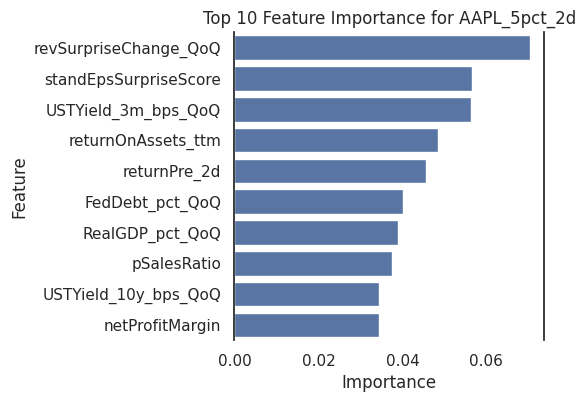

In [ ]:
# Get feature importances from the trained RandomForestClassifier
rfBest_feat_imp = rfBest.feature_importances_

# Create a DataFrame to display feature importances
rfBest_feat_imp_df = pd.DataFrame({'Feature': num_features, 'Importance': rfBest_feat_imp})

# Sort the DataFrame by importance in descending order
rfBest_feat_imp_df = rfBest_feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features of rfBest
title = f'Top 10 Feature Importance for {model_name}'
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=rfBest_feat_imp_df.head(10))
plt.title(title)
plt.xlabel('Importance')
plt.ylabel('Feature')
filename = f"{title.replace(' ', '_')}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Analysis and Model Considerations**

Ensemble models, by design, do not provide direct insight into how each feature influences predictions. However, analysing **feature importance rankings** offers valuable insights into the model’s decision-making process.

Many of the **top-ranked features align well with industry knowledge**, indicating that the model is capturing meaningful patterns. However, some features appear highly ranked despite being expected to have low to moderate influence on trading decisions based on fundamental reasoning.

This discrepancy suggests that the model may be detecting **spurious statistical patterns** rather than genuine predictive relationships. While these features might improve short-term accuracy, they do not necessarily provide real predictive value and could compromise the model’s stability over time.

The presence of potentially misleading features highlights the need for **continuous evaluation, periodic recalibration, and refinement** of the feature set. **Frequent reassessment** helps ensure that the model remains robust and does not overfit to patterns that arise purely by chance.

**Next Steps**
- **Feature Selection & Refinement**: Removing irrelevant or misleading features may enhance long-term model stability and performance.
- **Regular Model Audits**: Monitoring feature importance over time to detect shifts in predictive value.
- **Recalibration Strategy**: Adjusting the model at regular intervals to prevent overfitting to short-term patterns.

Refining the feature set should be a priority, as it can lead to a more resilient and interpretable model while maintaining strong predictive power.

### 2.1.4 Evaluate the strategy

**Train**

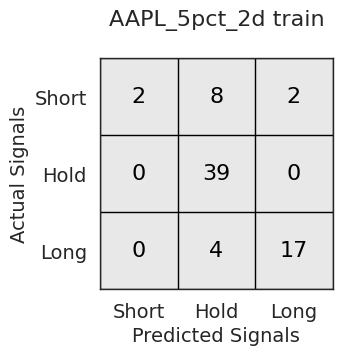

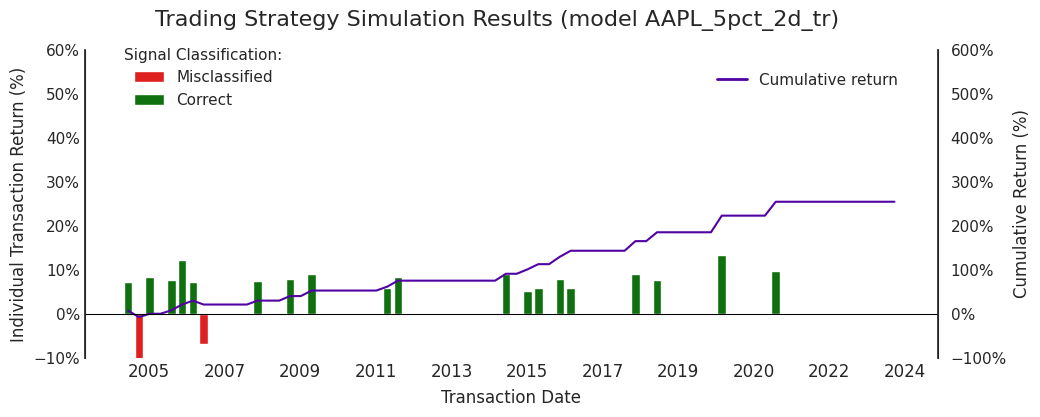

,AAPL_5pct_2d_tr
metric,
Return window,2.00
Signal Threshold,0.05
Number of observations,72.00
Number of true trading signals (opportunities),33.00
Number of predicted trading signals,21.00
Number of predicted trading signals (2023 -2024),0.00
Number of profitable trades,19.00
Recall for trading signals (identified opportunities),0.58
Precision for traded signals (correctly classified),0.90


In [ ]:
# calculate evaluation metrics
df_train = df[df['dataset'] == 'train']
df_train = calculate_strategy_returns(df_train, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col=signal_col)

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_train, y_train_pred, "train", model_name)
plot_strategy_evaluation(df_train, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 0.6), ax2_ylim=(-1, 6),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_tr)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_train, model_name=f'{model_name}_tr', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -1:]

**Training Performance:**

- The training dataset demonstrates high weighted average precision for traded signals (Long  and Short), meaning that when the model predicts a trading signal, it is very likely to be correct.
- The confusion matrix confirms that most predicted trades align with actual signals with high precision
- The number of profitable trades (win rate) is strong.
- No trading signals were generated in 2023–2024

**Interpretation:**
- The model’s high precision in training suggests that it effectively filters out weak signals, focusing only on high-confidence trades.
- However, this is expected in an in-sample environment, and further validation is required to assess its adaptability.
- The absence of trading signals in 2023–2024 may be due to feature drift or changes in company performance. The current Long/Short entry threshold of ±5% may be too restrictive, limiting signal generation. To address this, we will lower the entry threshold to ±4% and reassess the model’s performance.bility..

**Test**

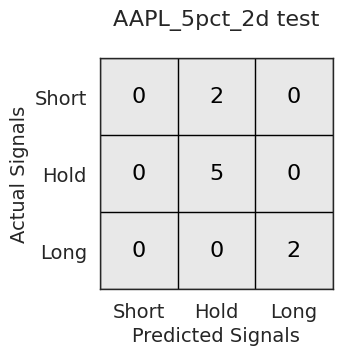

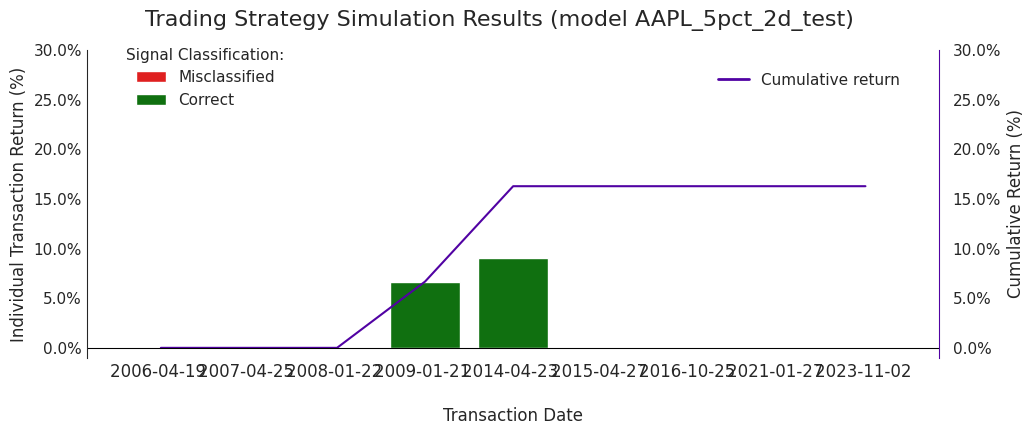

,AAPL_5pct_2d_tr,AAPL_5pct_2d_test
metric,,
Return window,2.00,2.00
Signal Threshold,0.05,0.05
Number of observations,72.00,9.00
Number of true trading signals (opportunities),33.00,4.00
Number of predicted trading signals,21.00,2.00
Number of predicted trading signals (2023 -2024),0.00,0.00
Number of profitable trades,19.00,2.00
Recall for trading signals (identified opportunities),0.58,0.50
Precision for traded signals (correctly classified),0.90,1.00


In [ ]:
# calculate strategy results
df_test = df[df['dataset'] == 'test']
df_test = calculate_strategy_returns(df_test, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_test, y_test_pred, "test", model_name)
plot_strategy_evaluation(df_test, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.01, 0.3), ax2_ylim=(-0.01, 0.3),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_test)',
                       use_datetime_labels=False)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_test, model_name=f'{model_name}_test',return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -2:]

**Test Performance:**
- The model exhibits high precision on the test dataset, even surpassing performance on the training dataset.

**Interpretation:**
- While precision improves in the test dataset, this should be interpreted cautiously due to the small number of test observations.
- A larger dataset would provide a clearer picture of whether this is a genuine issue with the model or just a reflection of the inherent randomness in a small sample size.

**Train & Test**

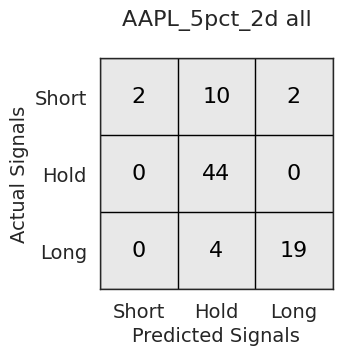

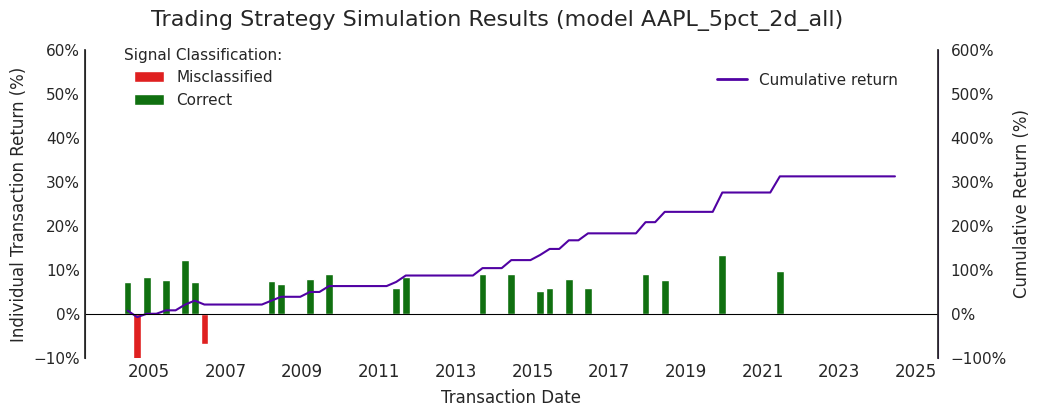

,AAPL_5pct_2d_tr,AAPL_5pct_2d_test,AAPL_5pct_2d_all
metric,,,
Return window,2.00,2.00,2.00
Signal Threshold,0.05,0.05,0.05
Number of observations,72.00,9.00,81.00
Number of true trading signals (opportunities),33.00,4.00,37.00
Number of predicted trading signals,21.00,2.00,23.00
Number of predicted trading signals (2023 -2024),0.00,0.00,0.00
Number of profitable trades,19.00,2.00,21.00
Recall for trading signals (identified opportunities),0.58,0.50,0.57
Precision for traded signals (correctly classified),0.90,1.00,0.91


In [ ]:
# calculate strategy results
df_all = calculate_strategy_returns(df, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')
df_all.to_csv(f'df_export {model_name}.csv')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(df['signal'], df['signal_pred'], "all", model_name)
plot_strategy_evaluation(df_all, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 0.6), ax2_ylim=(-1, 6),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_all)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_all, model_name=f'{model_name}_all', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -3:]

**Full dataset performance:**

The overall model demonstrates a strong ability to avoid false signals.

**Next steps:**
- While model demonstrates high precision both in the test and train datasets, this should be interpreted cautiously due to the small number of observations.
- Furthermore, the lack of trading signals in 2023–2024 raises concerns about the model’s ability to generate profitable signals in the future. To mitigate this, we will lower the entry threshold to ±4% and re-evaluate the model’s performance.

## 2.2 AAPL model 2

### 2.2.1 Define variables & map the true signal & train test split

**Define variables and strategy**

**Initial Setup:** The strategy begins with 100% cash and dynamically opens positions based on generated trading signals.

**Trading Signals:** The model predicts trading signals based on expected equity returns:

- **Long Position (1):** A long trade is initiated when the expected return exceeds the long entry threshold (hold_max).
The position remains open for a predefined holding period.

- **Short Position (-1):** A short trade is triggered when the expected price decline surpasses the short entry threshold (hold_min).

- **Hold (0):** No position is opened if neither a long nor short signal is generated.

In [ ]:
# Traded Asset & Data Range
model_name_subset = ['AAPL']  # List of traded assets
start_date = '2005-01-01'  # Start date for data analysis
model_name = ', '.join(model_name_subset) + '_4pct_2d' # Define a reference name for the model

# Signal Thresholds for Execution
hold_min = -0.04  # Short position threshold
hold_max = 0.04   # Long position threshold

# Trading Signal Parameters
signal_col = 'signal_pred'  # Column containing predicted signals
traded_signals = [-1, 1]     # -1: Short, 1: Long

# Return parameters
return_col = 'returnPost_2d'  # Column for post-signal returns
return_window = 2             # Return calculation window in days

**Apply the constrains, review, and label the data**

In [ ]:
# subset the data and review
df = df_full.copy()
df = df[(df['symbol'].isin(model_name_subset)) & (df['date'] >= start_date)]
display(df.info()), display(desc_stat_summary(df))

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 9 to 89
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             81 non-null     datetime64[ns]
 1   month                            81 non-null     string        
 2   weekday                          81 non-null     string        
 3   symbol                           81 non-null     string        
 4   returnPre_2d                     81 non-null     float64       
 5   returnPre_5d                     81 non-null     float64       
 6   BOP_SMA_10d                      81 non-null     float64       
 7   BOP_SMA_15d                      81 non-null     float64       
 8   closeCV_10d                      81 non-null     float64       
 9   closeCV_15d                      81 non-null     float64       
 10  epsSurprise_pct                  81 non-null     float64       
 11  

None

,count,mean,std,min,25%,50%,75%,max,Range,IQR,Skewness (n=0),Kurtosis (n=3),"Shapiro-Wilk, stat (n=1)","Shapiro-Wilk, p-value (>0.05)",Outliers (IQR),Outliers (Tukey),Outliers (Three-Sigma)
returnPre_2d,81.00,-0.00,0.03,-0.06,-0.01,-0.00,0.01,0.05,0.12,0.03,0.13,2.63,0.98,0.25,1,0,0
returnPre_5d,81.00,0.01,0.04,-0.13,-0.02,0.01,0.03,0.08,0.21,0.04,-0.70,4.51,0.95,0.00,3,0,2
BOP_SMA_10d,81.00,0.01,0.16,-0.38,-0.11,0.04,0.11,0.42,0.80,0.23,0.01,2.68,0.99,0.88,0,0,0
BOP_SMA_15d,81.00,0.01,0.14,-0.30,-0.08,0.03,0.10,0.35,0.65,0.17,-0.01,2.72,0.99,0.63,0,0,0
closeCV_10d,81.00,0.02,0.01,0.00,0.01,0.02,0.03,0.07,0.06,0.02,1.25,4.30,0.89,0.00,5,0,1
closeCV_15d,81.00,0.03,0.01,0.01,0.02,0.02,0.03,0.08,0.07,0.02,1.44,5.16,0.87,0.00,4,0,2
epsSurprise_pct,81.00,0.14,0.19,-0.11,0.03,0.07,0.19,1.20,1.31,0.16,3.05,15.66,0.71,0.00,4,2,2
epsSurpriseChange_QoQ,81.00,-0.01,0.18,-0.52,-0.05,-0.00,0.04,1.05,1.57,0.09,2.09,16.90,0.78,0.00,11,5,1
standEpsSurpriseScore,81.00,1.78,2.59,-1.01,0.41,0.94,2.20,17.72,18.73,1.79,3.51,19.75,0.66,0.00,7,3,1
revSurprise_pct,81.00,0.06,0.15,-0.37,0.01,0.04,0.14,0.45,0.82,0.13,-0.37,4.91,0.91,0.00,10,0,0


(None, None)

In [ ]:
# generate the True labels
df['signal'] = df[return_col].apply(lambda x: 1 if x > hold_max else (-1 if x < hold_min else 0))
df['signal'].value_counts(), df['signal'].value_counts().sum()

(signal
  1    32
  0    32
 -1    17
 Name: count, dtype: int64,
 81)

**Define features and split the data into train/test sets**

Note: Stratified Sampling to maintain the class distribution in both sets.

In [ ]:
# subset y-variables and numeric features.
y_variables = ['returnPost_2d', 'returnPost_5d', 'signal']
num_features = df.select_dtypes(include=['number']).columns.difference(y_variables).tolist()
display(f'X-features list: {num_features}')

# Set the variables:
X = df[num_features]
y = df['signal']

# Create train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

# Add train/test mapping to the original dataset
df['dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'

"X-features list: ['BOP_SMA_10d', 'BOP_SMA_15d', 'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'RealGDP_pct_QoQ', 'USTYield_10y_bps_QoQ', 'USTYield_2y_bps_QoQ', 'USTYield_3m_bps_QoQ', 'USTYield_5y_bps_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'closeCV_10d', 'closeCV_15d', 'currentRatio', 'debtToAssets', 'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', 'dividendPayoutRatio_ttm_YoY_bps', 'epsSurpriseChange_QoQ', 'epsSurprise_pct', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', 'pSalesRatio', 'peRatio', 'pre_macro_sentiment', 'pre_sentiment', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', 'returnOnEquity_ttm_YoY_bps', 'returnPre_2d', 'returnPre_5d', 'revSurpriseChange_QoQ', 'revSurprise_pct', 'revenueAct_YoY', 'revenue_qtly_YoY', 'standEpsSurpriseScore', 'standRevSurpriseScore', 'totalAssets_YoY']"

### 2.2.2 Fit & evaluate the baseline model

**Fit the model**

In [ ]:
# Create the and fit baseline model.
rf1 = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=2,
                             max_depth = 6,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

**View the Classification Report**

In [ ]:
# Print classification report of the preliminary random forest model
print(f"For train data in rf1 \n {classification_report(y_train, rf1.predict(X_train))}")
print(f"For test data in rf1 \n {classification_report(y_test, rf1.predict(X_test))}")

# Extract precision values
train_precision = extract_precision(classification_report(y_train, rf1.predict(X_train), output_dict=True))
test_precision = extract_precision(classification_report(y_test, rf1.predict(X_test), output_dict=True))

# Create DataFrame
data = {'Dataset': [f'rf1_Train {model_name}', f'rf1_Test {model_name}'],
        'Short': [train_precision['-1'], test_precision['-1']],
        'Hold': [train_precision['0'], test_precision['0']],
        'Long': [train_precision['1'], test_precision['1']],
        'wtAvg': [train_precision['weighted avg'], test_precision['weighted avg']]}

rf1_precision_df = pd.DataFrame(data)

summary_precision_df = rf1_precision_df.copy()

# Display precision from the classification report
summary_precision_df

For train data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        29

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

For test data in rf1 
               precision    recall  f1-score   support

          -1       1.00      0.50      0.67         2
           0       0.75      0.75      0.75         4
           1       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.75      0.64      0.66         9
weighted avg       0.72      0.67      0.67         9



,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train AAPL_4pct_2d,1.00,1.00,1.00,1.00
1,rf1_Test AAPL_4pct_2d,1.00,0.75,0.50,0.72


**Model performance evaluation:**

1) The baseline model overfits, achieving 100% accuracy across all metrics. This suggests that it has memorised the training data
2) The test weighted average precision demonstrates decent performance.  We note that the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

### 2.2.3 Hyperparameter Tuning, fit & evaluate the final Model

**Hyperparameter tuning approach:**

To optimise model performance, we apply RandomizedSearchCV for hyperparameter tuning.

Our primary objective is to minimise loss-making trades, even at the expense of missing some profitable opportunities. Since false positives for labels 1 (Long) and -1 (Short) can lead to significant costs, we focus on reducing incorrect trade executions. Consequently, we optimise for precision, ensuring that only high-confidence signals are acted upon. We use scoring='precision_weighted' to guide model optimisation, prioritising the reduction of misclassified trades.

The hyperparameter grid is designed considering the dataset size, class distribution, and the key evaluation metrics outlined above.


**Tuning Strategy**

- Search Method: RandomizedSearchCV (Efficient sampling across hyperparameters)
- Number of Iterations: n_iter=50 (Balances thorough exploration with computational efficiency)
- Cross-Validation: cv=10 (Ensures model generalisation across different data splits)
- Scoring Metric: precision_weighted (Prioritises avoiding incorrect buy/sell signals to minimise losses)
- Parallel Processing: n_jobs=-1 (Leverages all available cores for faster execution)



**Hyperparameter Grid & Rationale**

**n_estimators**: Number of trees in the ensemble
- Values: randint(50, 200)
- Rationale: A moderate range ensures sufficient model complexity while avoiding excessive overfitting or computation costs.

**max_depth**: Maximum depth of each tree
- Values: [3, 5, 7, None]
- Rationale: Controlling tree depth reduces the risk of overfitting, while None allows flexibility if deeper trees prove beneficial.

**min_samples_split**: Minimum samples required to split an internal node
- Values: randint(5, 15)
- Rationale: Higher thresholds prevent overfitting to small, noise-driven patterns, enforcing broader, more general decision rules.

**min_samples_leaf**: Minimum samples required at a leaf node
- Values: randint(2, 6)
- Rationale: Increasing the minimum leaf size reduces sensitivity to outliers and avoids making overly aggressive trading decisions based on limited data points.

**max_features**: Number of features considered at each split
- Values: ['sqrt', 'log2', None]
- Rationale: Randomly selecting features per split helps prevent over-reliance on specific indicators and improves generalisability.



In [ ]:
# Define hyperparameter distribution for tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(5, 15),
    'min_samples_leaf': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
}

# Initialise and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='precision_weighted',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best combination of hyperparameters found
print("Best parameters:", random_search.best_params_)

# Use best parameters to fit final model
rfBest = RandomForestClassifier(**random_search.best_params_,
                                n_jobs=-1,
                                random_state=42)
rfBest.fit(X_train, y_train)

# Assign variables to predicted signals
y_test_pred = rfBest.predict(X_test)
y_train_pred = rfBest.predict(X_train)
y_pred = rfBest.predict(X)

# Update the dataset with predicted signals
df['signal_pred'] = y_pred

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 100}


**Classification Report**

In [ ]:
# Print classification report of the Randomised Search random forest model
print(f"For train data in rfBest {model_name} \n {classification_report(y_train, rfBest.predict(X_train))}")
print(f"For test data in rfBest {model_name}\n {classification_report(y_test, rfBest.predict(X_test))}")
#print(f"For all data in rfBest {model_name} \n {classification_report(df['signal'], df['signal_pred'])}")

# Extract precision values
train_precision_best = extract_precision(classification_report(y_train, rfBest.predict(X_train), output_dict=True))
test_precision_best = extract_precision(classification_report(y_test, rfBest.predict(X_test), output_dict=True))

# Create DataFrame
data_best = {
    'Dataset': [f'rfBest_Train {model_name}', f'rfBest_Test {model_name}'],
    'Short': [train_precision_best['-1'], test_precision_best['-1']],
    'Hold': [train_precision_best['0'], test_precision_best['0']],
    'Long': [train_precision_best['1'], test_precision_best['1']],
    'wtAvg': [train_precision_best['weighted avg'], test_precision_best['weighted avg']]
}

rfBest_precision_df = pd.DataFrame(data_best)

summary_precision_df = pd.concat([summary_precision_df, rfBest_precision_df], ignore_index=True)
summary_precision_df.to_csv(f'summary_precision_{model_name}.csv', index=False)
print('Precision summary:')
summary_precision_df

For train data in rfBest AAPL_4pct_2d 
               precision    recall  f1-score   support

          -1       1.00      0.73      0.85        15
           0       0.90      0.96      0.93        28
           1       0.90      0.97      0.93        29

    accuracy                           0.92        72
   macro avg       0.93      0.89      0.90        72
weighted avg       0.92      0.92      0.91        72

For test data in rfBest AAPL_4pct_2d
               precision    recall  f1-score   support

          -1       0.50      0.50      0.50         2
           0       0.75      0.75      0.75         4
           1       0.33      0.33      0.33         3

    accuracy                           0.56         9
   macro avg       0.53      0.53      0.53         9
weighted avg       0.56      0.56      0.56         9

Precision summary:


,Dataset,Short,Hold,Long,wtAvg,Avg
0,rf1_Train AAPL_4pct_2d,1.00,1.00,1.00,1.00,NaN
1,rf1_Test AAPL_4pct_2d,1.00,0.75,0.50,0.72,NaN
2,rfBest_Train AAPL_4pct_2d,1.00,0.90,0.90,0.92,0.93
3,rfBest_Test AAPL_4pct_2d,0.50,0.75,0.33,0.56,0.53


**Model performance evaluation:**

1. The tuned model (rf_best) shows a slight reduction in training accuracy, which is a positive sign as it suggests the model has generalised better.
2. Test precision for both -1 (Short) and 1 (Long) remains suboptimal, with scores at 0.5 for Short and below for Long. This suggests that the model misclassifies Long signals more often than it predicts them correctly, while Short signals perform no better than random guessing.


**Feature Importances**

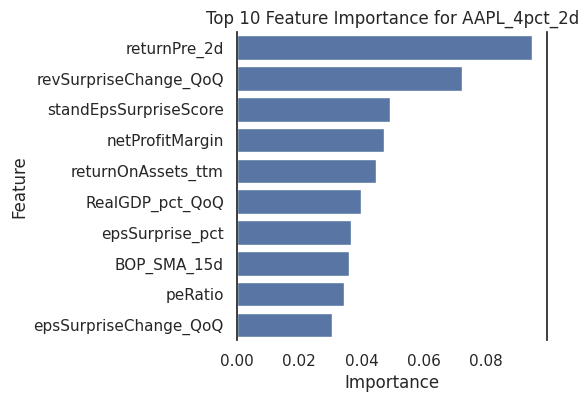

In [ ]:
# Get feature importances from the trained RandomForestClassifier
rfBest_feat_imp = rfBest.feature_importances_

# Create a DataFrame to display feature importances
rfBest_feat_imp_df = pd.DataFrame({'Feature': num_features, 'Importance': rfBest_feat_imp})

# Sort the DataFrame by importance in descending order
rfBest_feat_imp_df = rfBest_feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features of rfBest
title = f'Top 10 Feature Importance for {model_name}'
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=rfBest_feat_imp_df.head(10))
plt.title(title)
plt.xlabel('Importance')
plt.ylabel('Feature')
filename = f"{title.replace(' ', '_')}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Analysis and Model Considerations**

Ensemble models, by design, do not provide direct insight into how each feature influences predictions. However, analysing **feature importance rankings** offers valuable insights into the model’s decision-making process.

Many of the **top-ranked features align well with industry knowledge**, indicating that the model is capturing meaningful patterns. However, some features appear highly ranked despite being expected to have low to moderate influence on trading decisions based on fundamental reasoning.

This discrepancy suggests that the model may be detecting **spurious statistical patterns** rather than genuine predictive relationships. While these features might improve short-term accuracy, they do not necessarily provide real predictive value and could compromise the model’s stability over time.

The presence of potentially misleading features highlights the need for **continuous evaluation, periodic recalibration, and refinement** of the feature set. **Frequent reassessment** helps ensure that the model remains robust and does not overfit to patterns that arise purely by chance.

**Next Steps**
- **Feature Selection & Refinement**: Removing irrelevant or misleading features may enhance long-term model stability and performance.
- **Regular Model Audits**: Monitoring feature importance over time to detect shifts in predictive value.
- **Recalibration Strategy**: Adjusting the model at regular intervals to prevent overfitting to short-term patterns.

Refining the feature set should be a priority, as it can lead to a more resilient and interpretable model while maintaining strong predictive power.

### 2.2.4 Evaluate the strategy

**Train**

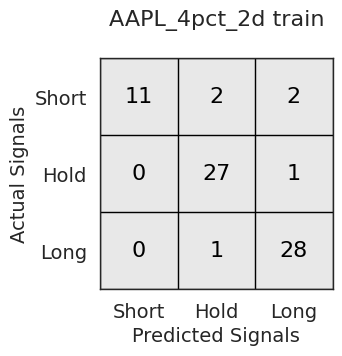

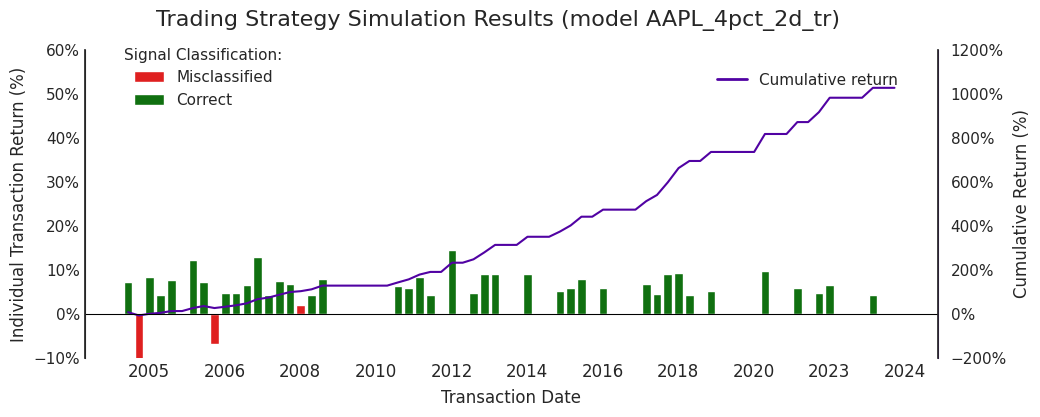

,AAPL_4pct_2d_tr
metric,
Return window,2.00
Signal Threshold,0.04
Number of observations,72.00
Number of true trading signals (opportunities),44.00
Number of predicted trading signals,42.00
Number of predicted trading signals (2023 -2024),3.00
Number of profitable trades,40.00
Recall for trading signals (identified opportunities),0.89
Precision for traded signals (correctly classified),0.93


In [ ]:
# calculate evaluation metrics
df_train = df[df['dataset'] == 'train']
df_train = calculate_strategy_returns(df_train, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col=signal_col)

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_train, y_train_pred, "train", model_name)
plot_strategy_evaluation(df_train, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 0.6), ax2_ylim=(-2, 12),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_tr)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_train, model_name=f'{model_name}_tr', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -1:]

**Training Performance:**

- The training dataset demonstrates high weighted average precision for traded signals (Long  and Short), meaning that when the model predicts a trading signal, it is very likely to be correct.
- The confusion matrix confirms that most predicted trades align with actual signals with high precision.
- The number of profitable trades (win rate) is strong.

**Interpretation:**
- The model’s high precision in training suggests that it effectively filters out weak signals, focusing only on high-confidence trades.
- However, this is expected in an in-sample environment, and further validation is required to assess its adaptability.

**Test**

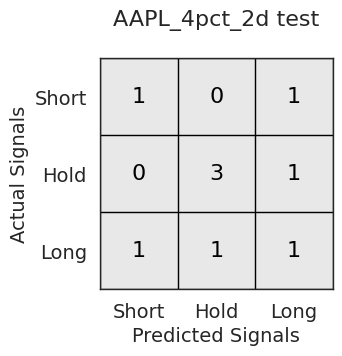

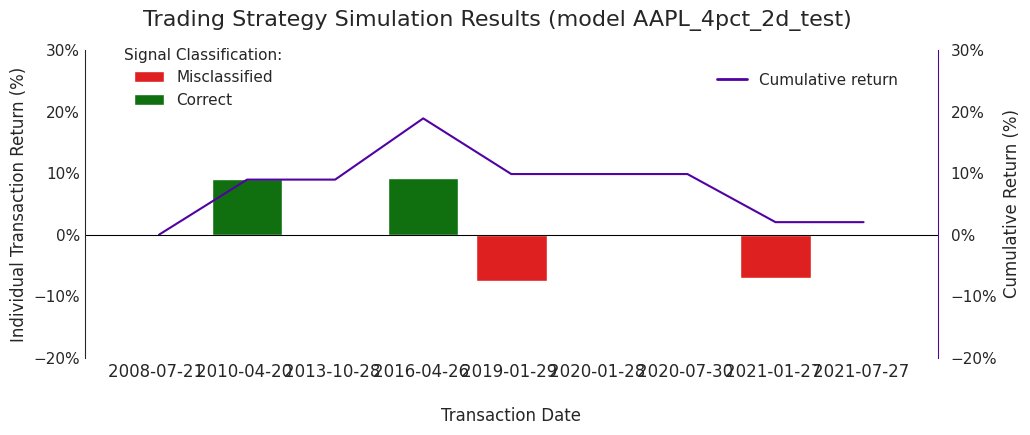

,AAPL_4pct_2d_tr,AAPL_4pct_2d_test
metric,,
Return window,2.00,2.00
Signal Threshold,0.04,0.04
Number of observations,72.00,9.00
Number of true trading signals (opportunities),44.00,5.00
Number of predicted trading signals,42.00,5.00
Number of predicted trading signals (2023 -2024),3.00,0.00
Number of profitable trades,40.00,2.00
Recall for trading signals (identified opportunities),0.89,0.40
Precision for traded signals (correctly classified),0.93,0.40


In [ ]:
# calculate strategy results
df_test = df[df['dataset'] == 'test']
df_test = calculate_strategy_returns(df_test, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_test, y_test_pred, "test", model_name)
plot_strategy_evaluation(df_test, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.2, 0.3), ax2_ylim=(-0.2, 0.3),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_test)',
                       use_datetime_labels=False)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_test, model_name=f'{model_name}_test',return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -2:]

**Test Performance:**

- The weighted average precision for traded signals (Long and Short) is below 50%, indicating that the model misclassifies signals more often than it predicts them correctly. This suggests that its predictive power is lower than random chance.

**Next Steps:**
- Lowering the entry threshold to ±4% did not produce the desired outcome, instead leading to a significant deterioration in model performance.
- Given these results, the current model is ineffective. We will explore a different return window to improve performance.






**Train & Test**

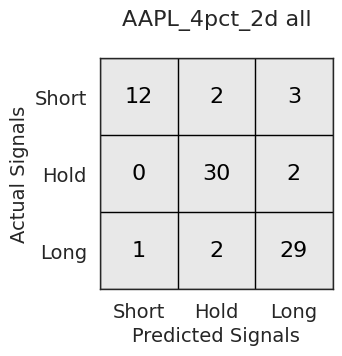

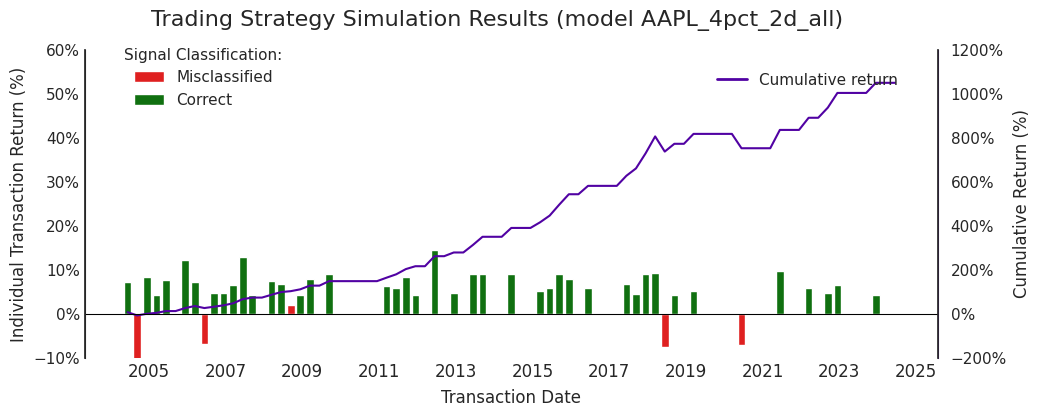

,AAPL_4pct_2d_tr,AAPL_4pct_2d_test,AAPL_4pct_2d_all
metric,,,
Return window,2.00,2.00,2.00
Signal Threshold,0.04,0.04,0.04
Number of observations,72.00,9.00,81.00
Number of true trading signals (opportunities),44.00,5.00,49.00
Number of predicted trading signals,42.00,5.00,47.00
Number of predicted trading signals (2023 -2024),3.00,0.00,3.00
Number of profitable trades,40.00,2.00,42.00
Recall for trading signals (identified opportunities),0.89,0.40,0.84
Precision for traded signals (correctly classified),0.93,0.40,0.87


In [ ]:
# calculate strategy results
df_all = calculate_strategy_returns(df, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')
df_all.to_csv(f'df_export {model_name}.csv')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(df['signal'], df['signal_pred'], "all", model_name)
plot_strategy_evaluation(df_all, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 0.6), ax2_ylim=(-2, 12),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_all)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_all, model_name=f'{model_name}_all', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -3:]

**Full dataset performance and Next Steps:**

Although the model effectively filters out false signals, its poor performance on the test dataset renders it ineffective. As a result, we will explore a different return window to improve its predictive capabilities.

## 2.3 AAPL model 3

### 2.3.1 Define variables & map the true signal & train test split

**Define variables and strategy**

**Initial Setup:** The strategy begins with 100% cash and dynamically opens positions based on generated trading signals.

**Trading Signals:** The model predicts trading signals based on expected equity returns:

- **Long Position (1):** A long trade is initiated when the expected return exceeds the long entry threshold (hold_max).
The position remains open for a predefined holding period.

- **Short Position (-1):** A short trade is triggered when the expected price decline surpasses the short entry threshold (hold_min).

- **Hold (0):** No position is opened if neither a long nor short signal is generated.

In [ ]:
# Traded Asset & Data Range
model_name_subset = ['AAPL']  # List of traded assets
start_date = '2005-01-01'  # Start date for data analysis
model_name = ', '.join(model_name_subset) + '_5pct_5d' # Define a reference name for the model

# Signal Thresholds for Execution
hold_min = -0.05  # Short position threshold
hold_max = 0.05   # Long position threshold

# Trading Signal Parameters
signal_col = 'signal_pred'  # Column containing predicted signals
traded_signals = [-1, 1]     # -1: Short, 1: Long

# Return parameters
return_col = 'returnPost_5d'  # Column for post-signal returns
return_window = 5             # Return calculation window in days

**Apply the constrains, review, and label the data**

In [ ]:
# subset the data and review
df = df_full.copy()
df = df[(df['symbol'].isin(model_name_subset)) & (df['date'] >= start_date)]
display(df.info()), display(desc_stat_summary(df))

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 9 to 89
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             81 non-null     datetime64[ns]
 1   month                            81 non-null     string        
 2   weekday                          81 non-null     string        
 3   symbol                           81 non-null     string        
 4   returnPre_2d                     81 non-null     float64       
 5   returnPre_5d                     81 non-null     float64       
 6   BOP_SMA_10d                      81 non-null     float64       
 7   BOP_SMA_15d                      81 non-null     float64       
 8   closeCV_10d                      81 non-null     float64       
 9   closeCV_15d                      81 non-null     float64       
 10  epsSurprise_pct                  81 non-null     float64       
 11  

None

,count,mean,std,min,25%,50%,75%,max,Range,IQR,Skewness (n=0),Kurtosis (n=3),"Shapiro-Wilk, stat (n=1)","Shapiro-Wilk, p-value (>0.05)",Outliers (IQR),Outliers (Tukey),Outliers (Three-Sigma)
returnPre_2d,81.00,-0.00,0.03,-0.06,-0.01,-0.00,0.01,0.05,0.12,0.03,0.13,2.63,0.98,0.25,1,0,0
returnPre_5d,81.00,0.01,0.04,-0.13,-0.02,0.01,0.03,0.08,0.21,0.04,-0.70,4.51,0.95,0.00,3,0,2
BOP_SMA_10d,81.00,0.01,0.16,-0.38,-0.11,0.04,0.11,0.42,0.80,0.23,0.01,2.68,0.99,0.88,0,0,0
BOP_SMA_15d,81.00,0.01,0.14,-0.30,-0.08,0.03,0.10,0.35,0.65,0.17,-0.01,2.72,0.99,0.63,0,0,0
closeCV_10d,81.00,0.02,0.01,0.00,0.01,0.02,0.03,0.07,0.06,0.02,1.25,4.30,0.89,0.00,5,0,1
closeCV_15d,81.00,0.03,0.01,0.01,0.02,0.02,0.03,0.08,0.07,0.02,1.44,5.16,0.87,0.00,4,0,2
epsSurprise_pct,81.00,0.14,0.19,-0.11,0.03,0.07,0.19,1.20,1.31,0.16,3.05,15.66,0.71,0.00,4,2,2
epsSurpriseChange_QoQ,81.00,-0.01,0.18,-0.52,-0.05,-0.00,0.04,1.05,1.57,0.09,2.09,16.90,0.78,0.00,11,5,1
standEpsSurpriseScore,81.00,1.78,2.59,-1.01,0.41,0.94,2.20,17.72,18.73,1.79,3.51,19.75,0.66,0.00,7,3,1
revSurprise_pct,81.00,0.06,0.15,-0.37,0.01,0.04,0.14,0.45,0.82,0.13,-0.37,4.91,0.91,0.00,10,0,0


(None, None)

In [ ]:
# generate the True labels
df['signal'] = df[return_col].apply(lambda x: 1 if x > hold_max else (-1 if x < hold_min else 0))
df['signal'].value_counts(), df['signal'].value_counts().sum()

(signal
  1    32
  0    32
 -1    17
 Name: count, dtype: int64,
 81)

**Define features and split the data into train/test sets**

Note: Stratified Sampling to maintain the class distribution in both sets.

In [ ]:
# subset y-variables and numeric features.
y_variables = ['returnPost_2d', 'returnPost_5d', 'signal']
num_features = df.select_dtypes(include=['number']).columns.difference(y_variables).tolist()
display(f'X-features list: {num_features}')

# Set the variables:
X = df[num_features]
y = df['signal']

# Create train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

# Add train/test mapping to the original dataset
df['dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'

"X-features list: ['BOP_SMA_10d', 'BOP_SMA_15d', 'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'RealGDP_pct_QoQ', 'USTYield_10y_bps_QoQ', 'USTYield_2y_bps_QoQ', 'USTYield_3m_bps_QoQ', 'USTYield_5y_bps_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'closeCV_10d', 'closeCV_15d', 'currentRatio', 'debtToAssets', 'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', 'dividendPayoutRatio_ttm_YoY_bps', 'epsSurpriseChange_QoQ', 'epsSurprise_pct', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', 'pSalesRatio', 'peRatio', 'pre_macro_sentiment', 'pre_sentiment', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', 'returnOnEquity_ttm_YoY_bps', 'returnPre_2d', 'returnPre_5d', 'revSurpriseChange_QoQ', 'revSurprise_pct', 'revenueAct_YoY', 'revenue_qtly_YoY', 'standEpsSurpriseScore', 'standRevSurpriseScore', 'totalAssets_YoY']"

### 2.3.2 Fit & evaluate the baseline model

**Fit the model**

In [ ]:
# Create the and fit baseline model.
rf1 = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=2,
                             max_depth = 6,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

**View the Classification Report**

In [ ]:
# Print classification report of the preliminary random forest model
print(f"For train data in rf1 \n {classification_report(y_train, rf1.predict(X_train))}")
print(f"For test data in rf1 \n {classification_report(y_test, rf1.predict(X_test))}")

# Extract precision values
train_precision = extract_precision(classification_report(y_train, rf1.predict(X_train), output_dict=True))
test_precision = extract_precision(classification_report(y_test, rf1.predict(X_test), output_dict=True))

# Create DataFrame
data = {'Dataset': [f'rf1_Train {model_name}', f'rf1_Test {model_name}'],
        'Short': [train_precision['-1'], test_precision['-1']],
        'Hold': [train_precision['0'], test_precision['0']],
        'Long': [train_precision['1'], test_precision['1']],
        'wtAvg': [train_precision['weighted avg'], test_precision['weighted avg']]}

rf1_precision_df = pd.DataFrame(data)

summary_precision_df = rf1_precision_df.copy()

# Display precision from the classification report
summary_precision_df

For train data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        29

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

For test data in rf1 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.50      0.50      0.50         4
           1       0.50      0.67      0.57         3

    accuracy                           0.44         9
   macro avg       0.33      0.39      0.36         9
weighted avg       0.39      0.44      0.41         9



,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train AAPL_5pct_5d,1.00,1.00,1.00,1.00
1,rf1_Test AAPL_5pct_5d,0.00,0.50,0.50,0.39


**Model performance evaluation:**

1) The baseline model overfits, achieving 100% accuracy across all metrics. This suggests that it has memorised the training data
2) The model's performance drops considerably on the test set, with a suboptimal weighted average precision score.
3) Precision for the test dataset is poor for both -1 (Short) and 1 (Long), indicating unreliable predictions.

### 2.3.3 Hyperparameter Tuning, fit & evaluate the final Model

**Hyperparameter tuning approach:**

To optimise model performance, we apply RandomizedSearchCV for hyperparameter tuning.

Our primary objective is to minimise loss-making trades, even at the expense of missing some profitable opportunities. Since false positives for labels 1 (Long) and -1 (Short) can lead to significant costs, we focus on reducing incorrect trade executions. Consequently, we optimise for precision, ensuring that only high-confidence signals are acted upon. We use scoring='precision_weighted' to guide model optimisation, prioritising the reduction of misclassified trades.

The hyperparameter grid is designed considering the dataset size, class distribution, and the key evaluation metrics outlined above.


**Tuning Strategy**

- Search Method: RandomizedSearchCV (Efficient sampling across hyperparameters)
- Number of Iterations: n_iter=50 (Balances thorough exploration with computational efficiency)
- Cross-Validation: cv=10 (Ensures model generalisation across different data splits)
- Scoring Metric: precision_weighted (Prioritises avoiding incorrect buy/sell signals to minimise losses)
- Parallel Processing: n_jobs=-1 (Leverages all available cores for faster execution)



**Hyperparameter Grid & Rationale**

**n_estimators**: Number of trees in the ensemble
- Values: randint(50, 200)
- Rationale: A moderate range ensures sufficient model complexity while avoiding excessive overfitting or computation costs.

**max_depth**: Maximum depth of each tree
- Values: [3, 5, 7, None]
- Rationale: Controlling tree depth reduces the risk of overfitting, while None allows flexibility if deeper trees prove beneficial.

**min_samples_split**: Minimum samples required to split an internal node
- Values: randint(5, 15)
- Rationale: Higher thresholds prevent overfitting to small, noise-driven patterns, enforcing broader, more general decision rules.

**min_samples_leaf**: Minimum samples required at a leaf node
- Values: randint(2, 6)
- Rationale: Increasing the minimum leaf size reduces sensitivity to outliers and avoids making overly aggressive trading decisions based on limited data points.

**max_features**: Number of features considered at each split
- Values: ['sqrt', 'log2', None]
- Rationale: Randomly selecting features per split helps prevent over-reliance on specific indicators and improves generalisability.



In [ ]:
# Define hyperparameter distribution for tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(5, 15),
    'min_samples_leaf': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
}

# Initialise and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='precision_weighted',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best combination of hyperparameters found
print("Best parameters:", random_search.best_params_)

# Use best parameters to fit final model
rfBest = RandomForestClassifier(**random_search.best_params_,
                                n_jobs=-1,
                                random_state=42)
rfBest.fit(X_train, y_train)

# Assign variables to predicted signals
y_test_pred = rfBest.predict(X_test)
y_train_pred = rfBest.predict(X_train)
y_pred = rfBest.predict(X)

# Update the dataset with predicted signals
df['signal_pred'] = y_pred

Best parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 84}


**Classification Report**

In [ ]:
# Print classification report of the Randomised Search random forest model
print(f"For train data in rfBest {model_name} \n {classification_report(y_train, rfBest.predict(X_train))}")
print(f"For test data in rfBest {model_name}\n {classification_report(y_test, rfBest.predict(X_test))}")
#print(f"For all data in rfBest {model_name} \n {classification_report(df['signal'], df['signal_pred'])}")

# Extract precision values
train_precision_best = extract_precision(classification_report(y_train, rfBest.predict(X_train), output_dict=True))
test_precision_best = extract_precision(classification_report(y_test, rfBest.predict(X_test), output_dict=True))

# Create DataFrame
data_best = {
    'Dataset': [f'rfBest_Train {model_name}', f'rfBest_Test {model_name}'],
    'Short': [train_precision_best['-1'], test_precision_best['-1']],
    'Hold': [train_precision_best['0'], test_precision_best['0']],
    'Long': [train_precision_best['1'], test_precision_best['1']],
    'wtAvg': [train_precision_best['weighted avg'], test_precision_best['weighted avg']]
}

rfBest_precision_df = pd.DataFrame(data_best)

summary_precision_df = pd.concat([summary_precision_df, rfBest_precision_df], ignore_index=True)
summary_precision_df.to_csv(f'summary_precision_{model_name}.csv', index=False)
print('Precision summary:')
summary_precision_df

For train data in rfBest AAPL_5pct_5d 
               precision    recall  f1-score   support

          -1       0.86      0.80      0.83        15
           0       0.93      0.89      0.91        28
           1       0.87      0.93      0.90        29

    accuracy                           0.89        72
   macro avg       0.88      0.87      0.88        72
weighted avg       0.89      0.89      0.89        72

For test data in rfBest AAPL_5pct_5d
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.67      0.50      0.57         4
           1       0.60      1.00      0.75         3

    accuracy                           0.56         9
   macro avg       0.42      0.50      0.44         9
weighted avg       0.50      0.56      0.50         9

Precision summary:


,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train AAPL_5pct_5d,1.00,1.00,1.00,1.00
1,rf1_Test AAPL_5pct_5d,0.00,0.50,0.50,0.39
2,rfBest_Train AAPL_5pct_5d,0.86,0.93,0.87,0.89
3,rfBest_Test AAPL_5pct_5d,0.00,0.67,0.60,0.50


**Model performance evaluation:**

1. The tuned model (rf_best) shows a slight reduction in training accuracy, which is a positive sign as it suggests the model has generalised better.
2. Test precision for both -1 (Short) and 1 (Long) has improved compared to the baseline, suggesting better generalisation and aligning with the objective of reducing false positives for Long and Short signals.

**Feature Importances**

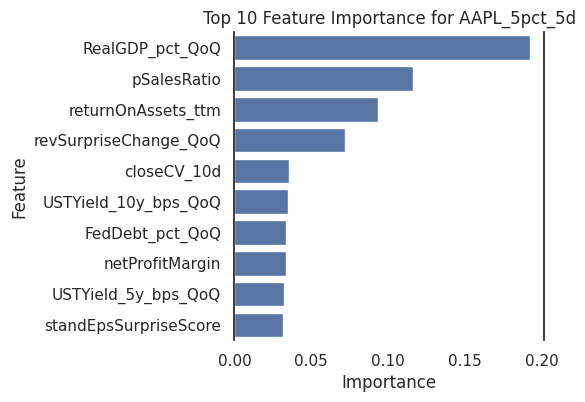

In [ ]:
# Get feature importances from the trained RandomForestClassifier
rfBest_feat_imp = rfBest.feature_importances_

# Create a DataFrame to display feature importances
rfBest_feat_imp_df = pd.DataFrame({'Feature': num_features, 'Importance': rfBest_feat_imp})

# Sort the DataFrame by importance in descending order
rfBest_feat_imp_df = rfBest_feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features of rfBest
title = f'Top 10 Feature Importance for {model_name}'
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=rfBest_feat_imp_df.head(10))
plt.title(title)
plt.xlabel('Importance')
plt.ylabel('Feature')
filename = f"{title.replace(' ', '_')}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Analysis and Model Considerations**

Ensemble models, by design, do not provide direct insight into how each feature influences predictions. However, analysing **feature importance rankings** offers valuable insights into the model’s decision-making process.

Many of the **top-ranked features align well with industry knowledge**, indicating that the model is capturing meaningful patterns. However, some features appear highly ranked despite being expected to have low to moderate influence on trading decisions based on fundamental reasoning.

This discrepancy suggests that the model may be detecting **spurious statistical patterns** rather than genuine predictive relationships. While these features might improve short-term accuracy, they do not necessarily provide real predictive value and could compromise the model’s stability over time.

The presence of potentially misleading features highlights the need for **continuous evaluation, periodic recalibration, and refinement** of the feature set. **Frequent reassessment** helps ensure that the model remains robust and does not overfit to patterns that arise purely by chance.

**Next Steps**
- **Feature Selection & Refinement**: Removing irrelevant or misleading features may enhance long-term model stability and performance.
- **Regular Model Audits**: Monitoring feature importance over time to detect shifts in predictive value.
- **Recalibration Strategy**: Adjusting the model at regular intervals to prevent overfitting to short-term patterns.

Refining the feature set should be a priority, as it can lead to a more resilient and interpretable model while maintaining strong predictive power.

### 2.3.4 Evaluate the strategy

**Train**

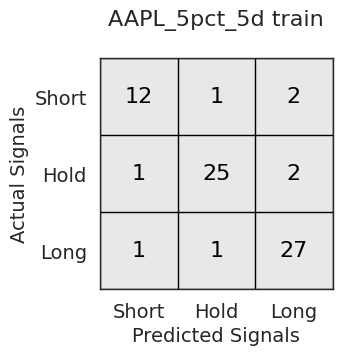

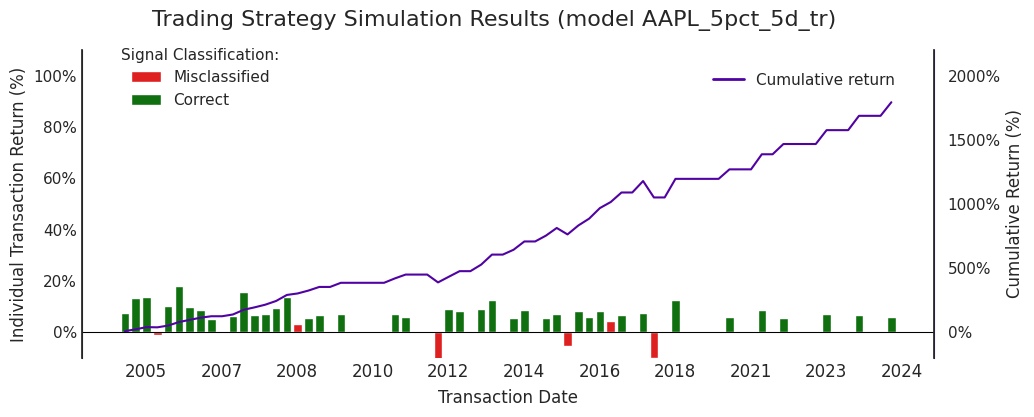

,AAPL_5pct_5d_tr
metric,
Return window,5.00
Signal Threshold,0.05
Number of observations,72.00
Number of true trading signals (opportunities),44.00
Number of predicted trading signals,45.00
Number of predicted trading signals (2023 -2024),3.00
Number of profitable trades,41.00
Recall for trading signals (identified opportunities),0.89
Precision for traded signals (correctly classified),0.87


In [ ]:
# calculate evaluation metrics
df_train = df[df['dataset'] == 'train']
df_train = calculate_strategy_returns(df_train, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col=signal_col)

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_train, y_train_pred, "train", model_name)
plot_strategy_evaluation(df_train, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 1.1), ax2_ylim=(-2, 22),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_tr)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_train, model_name=f'{model_name}_tr', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -1:]

**Training Performance:**

- The training dataset demonstrates high weighted average precision for traded signals (Long  and Short), meaning that when the model predicts a trading signal, it is very likely to be correct.
- The confusion matrix confirms that most predicted trades align with actual signals with high precision
- The number of profitable trades (win rate) is strong.

**Interpretation:**
- The model’s high precision in training suggests that it effectively filters out weak signals, focusing only on high-confidence trades.
- However, this is expected in an in-sample environment, and further validation is required to assess its adaptability..

**Test**

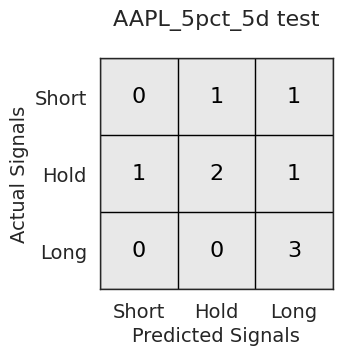

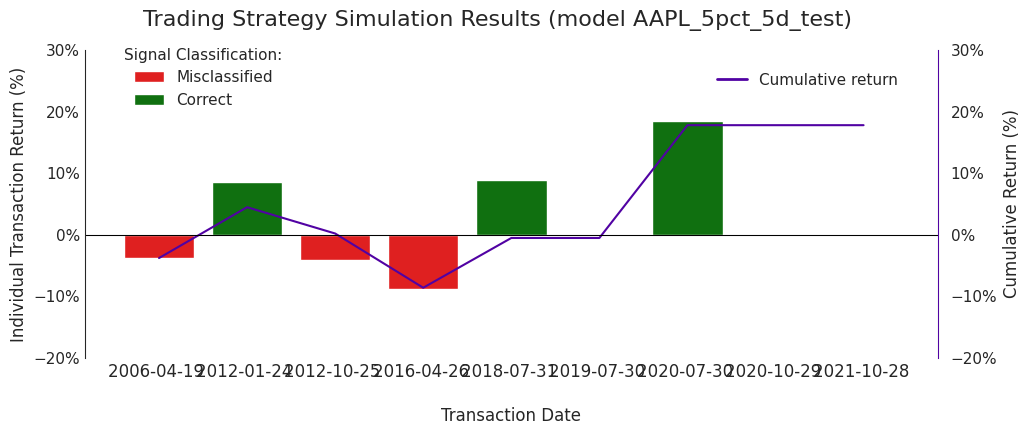

,AAPL_5pct_5d_tr,AAPL_5pct_5d_test
metric,,
Return window,5.00,5.00
Signal Threshold,0.05,0.05
Number of observations,72.00,9.00
Number of true trading signals (opportunities),44.00,5.00
Number of predicted trading signals,45.00,6.00
Number of predicted trading signals (2023 -2024),3.00,0.00
Number of profitable trades,41.00,3.00
Recall for trading signals (identified opportunities),0.89,0.60
Precision for traded signals (correctly classified),0.87,0.50


In [ ]:
# calculate strategy results
df_test = df[df['dataset'] == 'test']
df_test = calculate_strategy_returns(df_test, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_test, y_test_pred, "test", model_name)
plot_strategy_evaluation(df_test, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.2, 0.3), ax2_ylim=(-0.2, 0.3),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_test)',
                       use_datetime_labels=False)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_test, model_name=f'{model_name}_test',return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -2:]

**Test Performance:**

- Weighted average precision for traded signals (Long  and Short)  is 50% and is lower compared to the training set metric, suggesting that the model's predictive power is comparable with random chance. However, the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

**Interpretation:**
- While precision drops in the test dataset, this should be interpreted cautiously due to the small number of test observations.
- The model still delivers a positive average return per trade even though the precision is not optimal.
- The model yields a cumulative return of 17.7% over the 6 signals traded. At the same time, we should acknowledge the fact that the misclassified trade signals result in a temporary max loss of 12.5%.
- A larger dataset would provide a clearer picture of whether this is a genuine issue with the model or just a reflection of the inherent randomness in a small sample size.


**Train & Test**

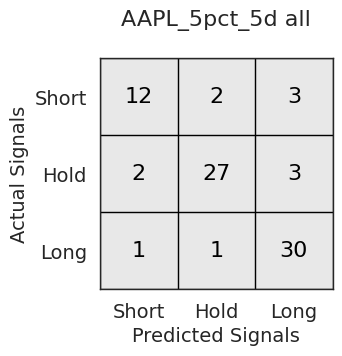

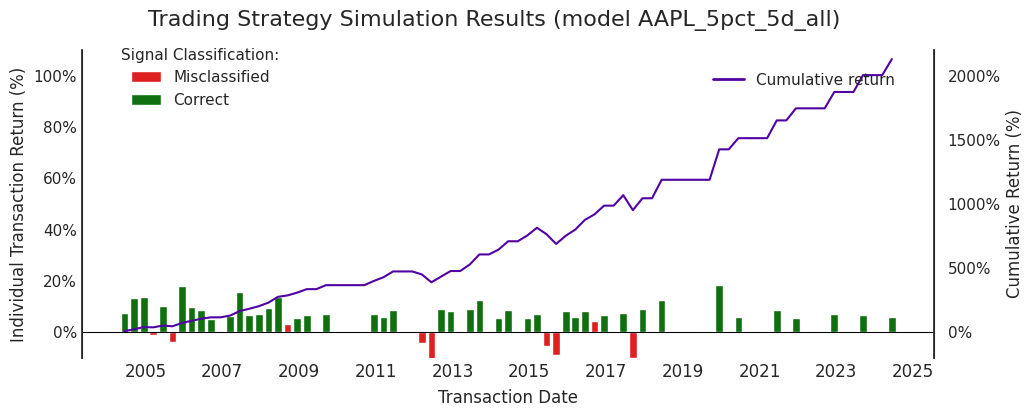

,AAPL_5pct_5d_tr,AAPL_5pct_5d_test,AAPL_5pct_5d_all
metric,,,
Return window,5.00,5.00,5.00
Signal Threshold,0.05,0.05,0.05
Number of observations,72.00,9.00,81.00
Number of true trading signals (opportunities),44.00,5.00,49.00
Number of predicted trading signals,45.00,6.00,51.00
Number of predicted trading signals (2023 -2024),3.00,0.00,3.00
Number of profitable trades,41.00,3.00,44.00
Recall for trading signals (identified opportunities),0.89,0.60,0.86
Precision for traded signals (correctly classified),0.87,0.50,0.82


In [ ]:
# calculate strategy results
df_all = calculate_strategy_returns(df, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')
df_all.to_csv(f'df_export {model_name}.csv')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(df['signal'], df['signal_pred'], "all", model_name)
plot_strategy_evaluation(df_all, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                       ax1_ylim=(-0.1, 1.1), ax2_ylim=(-2, 22),
                       x_label_rotation=0, x_label_fontsize=12,
                       plot_name=f'Trading Strategy Simulation Results (model {model_name}_all)',
                       use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_all, model_name=f'{model_name}_all', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -3:]

**Full dataset performance:**

Although test results show some variability, the overall model demonstrates a strong ability to avoid false signals.

**Next steps:**
- More data would help confirm whether the observed drop in precision in the test set is a structural issue or just a sample size effect.
- Ensuring only relevant features are contributing to signals could further stabilise precision.
- Regular evaluation will help determine whether precision fluctuations are due to market conditions or model behaviour.
  

## 2.4 AAPL model selection

In [ ]:
model_evaluation_summary.to_csv('AAPL_model_evaluation_summary.csv')

model_evaluation_summary.style \
    .set_table_styles([{'selector': 'th, td', 'props': [('font-size', '10px')]}]) \
    .set_properties(**{'text-align': 'center'}) \
    .format(precision=2)

,AAPL_5pct_2d_tr,AAPL_5pct_2d_test,AAPL_5pct_2d_all,AAPL_4pct_2d_tr,AAPL_4pct_2d_test,AAPL_4pct_2d_all,AAPL_5pct_5d_tr,AAPL_5pct_5d_test,AAPL_5pct_5d_all
metric,,,,,,,,,
Return window,2.00,2.00,2.00,2.00,2.00,2.00,5.00,5.00,5.00
Signal Threshold,0.05,0.05,0.05,0.04,0.04,0.04,0.05,0.05,0.05
Number of observations,72.00,9.00,81.00,72.00,9.00,81.00,72.00,9.00,81.00
Number of true trading signals (opportunities),33.00,4.00,37.00,44.00,5.00,49.00,44.00,5.00,49.00
Number of predicted trading signals,21.00,2.00,23.00,42.00,5.00,47.00,45.00,6.00,51.00
Number of predicted trading signals (2023 -2024),0.00,0.00,0.00,3.00,0.00,3.00,3.00,0.00,3.00
Number of profitable trades,19.00,2.00,21.00,40.00,2.00,42.00,41.00,3.00,44.00
Recall for trading signals (identified opportunities),0.58,0.50,0.57,0.89,0.40,0.84,0.89,0.60,0.86
Precision for traded signals (correctly classified),0.90,1.00,0.91,0.93,0.40,0.87,0.87,0.50,0.82


**Model selection:**

- While the **AAPL_5pct_2d** model demonstrates high precision in both the test and training datasets, **the absence of trading signals in 2023–2024 raises concerns about its ability to generate profitable signals in the future**.

- The **AAPL_4pct_2d** model performs poorly on the test dataset, with a weighted average precision for traded signals (Long and Short) below 50%. This indicates that it **misclassifies signals more often than it predicts them correctly**, rendering the model ineffective.

- Based on the evaluation of all models, **AAPL_5pct_5d appears to best align with the project's objectives**. While its test precision is not optimal (50%), it still delivers a positive average return per trade, a cumulative return of 17.7%, and remains the most viable option among the tested models. Despite a maximum drawdown of 12.5%, the model demonstrates profitability, making it the most suitable choice given the available data.

Given the small test dataset, the results should be interpreted with caution. The actual model performance **may deviate from the test assessment in either direction**, as the limited number of observations can distort the impact of misclassified trades. To gain a clearer understanding of its effectiveness, we should **monitor the AAPL_5pct_5d model’s performance** or conduct **additional testing on newly accumulated data in future periods before making final conclusions.**

In [ ]:
model_evaluation_summary.columns

Index(['AAPL_5pct_2d_tr', 'AAPL_5pct_2d_test', 'AAPL_5pct_2d_all',
       'AAPL_4pct_2d_tr', 'AAPL_4pct_2d_test', 'AAPL_4pct_2d_all',
       'AAPL_5pct_5d_tr', 'AAPL_5pct_5d_test', 'AAPL_5pct_5d_all'],
      dtype='object')

In [ ]:
model_evaluation_summary = model_evaluation_summary[['AAPL_5pct_5d_tr', 'AAPL_5pct_5d_test', 'AAPL_5pct_5d_all']]

# 3. GOOGL

## 3.1 GOOGL model 1

### 3.1.1 Define variables & map the true signal & train test split

**Define variables and strategy**

**Initial Setup:** The strategy begins with 100% cash and dynamically opens positions based on generated trading signals.

**Trading Signals:** The model predicts trading signals based on expected equity returns:

- **Long Position (1):** A long trade is initiated when the expected return exceeds the long entry threshold (hold_max).
The position remains open for a predefined holding period.

- **Short Position (-1):** A short trade is triggered when the expected price decline surpasses the short entry threshold (hold_min).

- **Hold (0):** No position is opened if neither a long nor short signal is generated.

In [ ]:
# Traded Asset & Data Range
model_name_subset = ['GOOGL']  # List of traded assets
start_date = '2005-01-01'  # Start date for data analysis
model_name = ', '.join(model_name_subset) + '_5pct_2d' # Define a reference name for the model

# Signal Thresholds for Execution
hold_min = -0.05  # Short position threshold
hold_max = 0.05   # Long position threshold

# Trading Signal Parameters
signal_col = 'signal_pred'  # Column containing predicted signals
traded_signals = [-1, 1]     # -1: Short, 1: Long

# Return parameters
return_col = 'returnPost_2d'  # Column for post-signal returns
return_window = 2            # Return calculation window in days

**Apply the constrains, review, and label the data**

In [ ]:
# subset the data and review
df = df_full.copy()
df = df[(df['symbol'].isin(model_name_subset)) & (df['date'] >= start_date)]
display(df.info()), display(desc_stat_summary(df))

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 410 to 489
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             80 non-null     datetime64[ns]
 1   month                            80 non-null     string        
 2   weekday                          80 non-null     string        
 3   symbol                           80 non-null     string        
 4   returnPre_2d                     80 non-null     float64       
 5   returnPre_5d                     80 non-null     float64       
 6   BOP_SMA_10d                      80 non-null     float64       
 7   BOP_SMA_15d                      80 non-null     float64       
 8   closeCV_10d                      80 non-null     float64       
 9   closeCV_15d                      80 non-null     float64       
 10  epsSurprise_pct                  80 non-null     float64       
 1

None

,count,mean,std,min,25%,50%,75%,max,Range,IQR,Skewness (n=0),Kurtosis (n=3),"Shapiro-Wilk, stat (n=1)","Shapiro-Wilk, p-value (>0.05)",Outliers (IQR),Outliers (Tukey),Outliers (Three-Sigma)
returnPre_2d,80.00,0.01,0.02,-0.11,-0.01,0.01,0.02,0.09,0.20,0.03,-0.82,8.83,0.91,0.00,2,1,2
returnPre_5d,80.00,0.01,0.04,-0.09,-0.01,0.01,0.03,0.10,0.19,0.04,0.14,3.54,0.98,0.13,4,0,0
BOP_SMA_10d,80.00,0.01,0.16,-0.29,-0.11,-0.00,0.14,0.45,0.73,0.25,0.21,2.62,0.98,0.14,0,0,0
BOP_SMA_15d,80.00,0.03,0.13,-0.38,-0.05,0.04,0.12,0.33,0.70,0.17,-0.22,3.30,0.99,0.72,1,0,1
closeCV_10d,80.00,0.02,0.01,0.01,0.01,0.02,0.03,0.07,0.06,0.01,1.54,6.22,0.87,0.00,3,1,1
closeCV_15d,80.00,0.02,0.01,0.01,0.01,0.02,0.03,0.09,0.08,0.01,2.28,10.92,0.81,0.00,6,2,2
epsSurprise_pct,80.00,0.08,0.14,-0.15,0.00,0.06,0.13,0.66,0.81,0.13,1.34,5.90,0.91,0.00,5,1,1
epsSurpriseChange_QoQ,79.00,-0.00,0.15,-0.40,-0.08,-0.00,0.10,0.35,0.75,0.18,-0.02,3.11,0.99,0.85,1,0,0
standEpsSurpriseScore,76.00,0.92,1.62,-3.35,0.00,0.88,1.91,5.10,8.45,1.91,0.08,3.10,0.98,0.49,2,0,0
revSurprise_pct,80.00,0.05,0.13,-0.53,-0.01,0.04,0.12,0.45,0.98,0.13,-0.36,8.91,0.88,0.00,3,1,3


(None, None)

In [ ]:
# generate the True labels
df['signal'] = df[return_col].apply(lambda x: 1 if x > hold_max else (-1 if x < hold_min else 0))
df['signal'].value_counts(), df['signal'].value_counts().sum()

(signal
  0    39
  1    24
 -1    17
 Name: count, dtype: int64,
 80)

**Define features and split the data into train/test sets**

Note: Stratified Sampling to maintain the class distribution in both sets.

In [ ]:
# subset y-variables and numeric features.
y_variables = ['returnPost_2d', 'returnPost_5d', 'signal']
num_features = df.select_dtypes(include=['number']).columns.difference(y_variables).tolist()
display(f'X-features list: {num_features}')

# Set the variables:
X = df[num_features]
y = df['signal']

# Create train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

# Add train/test mapping to the original dataset
df['dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'

"X-features list: ['BOP_SMA_10d', 'BOP_SMA_15d', 'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'RealGDP_pct_QoQ', 'USTYield_10y_bps_QoQ', 'USTYield_2y_bps_QoQ', 'USTYield_3m_bps_QoQ', 'USTYield_5y_bps_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'closeCV_10d', 'closeCV_15d', 'currentRatio', 'debtToAssets', 'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', 'dividendPayoutRatio_ttm_YoY_bps', 'epsSurpriseChange_QoQ', 'epsSurprise_pct', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', 'pSalesRatio', 'peRatio', 'pre_macro_sentiment', 'pre_sentiment', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', 'returnOnEquity_ttm_YoY_bps', 'returnPre_2d', 'returnPre_5d', 'revSurpriseChange_QoQ', 'revSurprise_pct', 'revenueAct_YoY', 'revenue_qtly_YoY', 'standEpsSurpriseScore', 'standRevSurpriseScore', 'totalAssets_YoY']"

### 3.1.2 Fit & evaluate the baseline model

**Fit the model**

In [ ]:
# Create the and fit baseline model.
rf1 = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=2,
                             max_depth = 6,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

**View the Classification Report**

In [ ]:
# Print classification report of the preliminary random forest model
print(f"For train data in rf1 \n {classification_report(y_train, rf1.predict(X_train))}")
print(f"For test data in rf1 \n {classification_report(y_test, rf1.predict(X_test))}")

# Extract precision values
train_precision = extract_precision(classification_report(y_train, rf1.predict(X_train), output_dict=True))
test_precision = extract_precision(classification_report(y_test, rf1.predict(X_test), output_dict=True))

# Create DataFrame
data = {'Dataset': [f'rf1_Train {model_name}', f'rf1_Test {model_name}'],
        'Short': [train_precision['-1'], test_precision['-1']],
        'Hold': [train_precision['0'], test_precision['0']],
        'Long': [train_precision['1'], test_precision['1']],
        'wtAvg': [train_precision['weighted avg'], test_precision['weighted avg']]}

rf1_precision_df = pd.DataFrame(data)

summary_precision_df = rf1_precision_df.copy()

# Display precision from the classification report
summary_precision_df

For train data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        15
           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        22

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

For test data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00         2
           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train GOOGL_5pct_2d,1.00,1.00,1.00,1.00
1,rf1_Test GOOGL_5pct_2d,1.00,0.75,0.50,0.75


**Model performance evaluation:**

1) The baseline model overfits, achieving 100% accuracy across all metrics. This suggests that it has memorised the training data
2) However, test weighted average precision demonstrates decent performance. We note that the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

### 3.1.3 Hyperparameter Tuning, fit & evaluate the final Model

**Hyperparameter tuning approach:**

To optimise model performance, we apply RandomizedSearchCV for hyperparameter tuning.

Our primary objective is to minimise loss-making trades, even at the expense of missing some profitable opportunities. Since false positives for labels 1 (Long) and -1 (Short) can lead to significant costs, we focus on reducing incorrect trade executions. Consequently, we optimise for precision, ensuring that only high-confidence signals are acted upon. We use scoring='precision_weighted' to guide model optimisation, prioritising the reduction of misclassified trades.

The hyperparameter grid is designed considering the dataset size, class distribution, and the key evaluation metrics outlined above.


**Tuning Strategy**

- Search Method: RandomizedSearchCV (Efficient sampling across hyperparameters)
- Number of Iterations: n_iter=50 (Balances thorough exploration with computational efficiency)
- Cross-Validation: cv=10 (Ensures model generalisation across different data splits)
- Scoring Metric: precision_weighted (Prioritises avoiding incorrect buy/sell signals to minimise losses)
- Parallel Processing: n_jobs=-1 (Leverages all available cores for faster execution)



**Hyperparameter Grid & Rationale**

**n_estimators**: Number of trees in the ensemble
- Values: randint(50, 200)
- Rationale: A moderate range ensures sufficient model complexity while avoiding excessive overfitting or computation costs.

**max_depth**: Maximum depth of each tree
- Values: [3, 5, 7, None]
- Rationale: Controlling tree depth reduces the risk of overfitting, while None allows flexibility if deeper trees prove beneficial.

**min_samples_split**: Minimum samples required to split an internal node
- Values: randint(5, 15)
- Rationale: Higher thresholds prevent overfitting to small, noise-driven patterns, enforcing broader, more general decision rules.

**min_samples_leaf**: Minimum samples required at a leaf node
- Values: randint(2, 6)
- Rationale: Increasing the minimum leaf size reduces sensitivity to outliers and avoids making overly aggressive trading decisions based on limited data points.

**max_features**: Number of features considered at each split
- Values: ['sqrt', 'log2', None]
- Rationale: Randomly selecting features per split helps prevent over-reliance on specific indicators and improves generalisability.



In [ ]:
# Define hyperparameter distribution for tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(5, 15),
    'min_samples_leaf': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
}

# Initialise and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='precision_weighted',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best combination of hyperparameters found
print("Best parameters:", random_search.best_params_)

# Use best parameters to fit final model
rfBest = RandomForestClassifier(**random_search.best_params_,
                                n_jobs=-1,
                                random_state=42)
rfBest.fit(X_train, y_train)

# Assign variables to predicted signals
y_test_pred = rfBest.predict(X_test)
y_train_pred = rfBest.predict(X_train)
y_pred = rfBest.predict(X)

# Update the dataset with predicted signals
df['signal_pred'] = y_pred

Best parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 82}


**Classification Report**

In [ ]:
# Print classification report of the Randomised Search random forest model
print(f"For train data in rfBest {model_name} \n {classification_report(y_train, rfBest.predict(X_train))}")
print(f"For test data in rfBest {model_name}\n {classification_report(y_test, rfBest.predict(X_test))}")
#print(f"For all data in rfBest {model_name} \n {classification_report(df['signal'], df['signal_pred'])}")

# Extract precision values
train_precision_best = extract_precision(classification_report(y_train, rfBest.predict(X_train), output_dict=True))
test_precision_best = extract_precision(classification_report(y_test, rfBest.predict(X_test), output_dict=True))

# Create DataFrame
data_best = {
    'Dataset': [f'rfBest_Train {model_name}', f'rfBest_Test {model_name}'],
    'Short': [train_precision_best['-1'], test_precision_best['-1']],
    'Hold': [train_precision_best['0'], test_precision_best['0']],
    'Long': [train_precision_best['1'], test_precision_best['1']],
    'wtAvg': [train_precision_best['weighted avg'], test_precision_best['weighted avg']]
}

rfBest_precision_df = pd.DataFrame(data_best)

summary_precision_df = pd.concat([summary_precision_df, rfBest_precision_df], ignore_index=True)
summary_precision_df.to_csv(f'summary_precision_{model_name}.csv', index=False)
print('Precision summary:')
summary_precision_df

For train data in rfBest GOOGL_5pct_2d 
               precision    recall  f1-score   support

          -1       0.94      1.00      0.97        15
           0       0.94      0.97      0.96        35
           1       1.00      0.91      0.95        22

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

For test data in rfBest GOOGL_5pct_2d
               precision    recall  f1-score   support

          -1       0.50      0.50      0.50         2
           0       0.60      0.75      0.67         4
           1       1.00      0.50      0.67         2

    accuracy                           0.62         8
   macro avg       0.70      0.58      0.61         8
weighted avg       0.68      0.62      0.62         8

Precision summary:


,Dataset,Short,Hold,Long,wtAvg,Avg
0,rf1_Train GOOGL_5pct_2d,1.00,1.00,1.00,1.00,NaN
1,rf1_Test GOOGL_5pct_2d,1.00,0.75,0.50,0.75,NaN
2,rfBest_Train GOOGL_5pct_2d,0.94,0.94,1.00,0.96,0.96
3,rfBest_Test GOOGL_5pct_2d,0.50,0.60,1.00,0.68,0.70


**Model performance evaluation:**

1. The tuned model (rf_best) shows a slight reduction in training accuracy, which is a positive sign suggesting the model has generalised better.
2. Test weighted average precision is decent. Class precision for both -1 (Short) and 1 (Long) demonstrably exceeds 50% suggesting that the model has predictive power.  However, we note that the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

**Feature Importances**

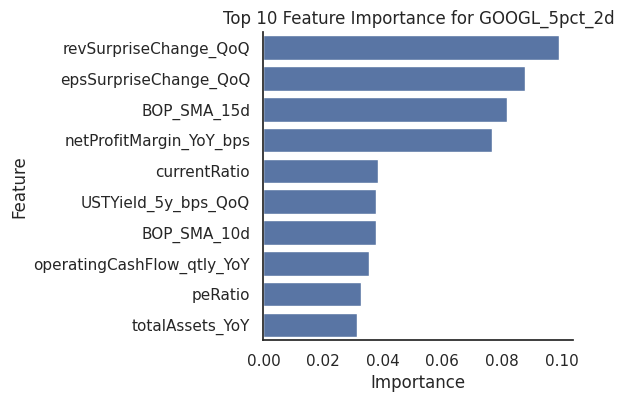

In [ ]:
# Get feature importances from the trained RandomForestClassifier
rfBest_feat_imp = rfBest.feature_importances_

# Create a DataFrame to display feature importances
rfBest_feat_imp_df = pd.DataFrame({'Feature': num_features, 'Importance': rfBest_feat_imp})

# Sort the DataFrame by importance in descending order
rfBest_feat_imp_df = rfBest_feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features of rfBest
title = f'Top 10 Feature Importance for {model_name}'
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=rfBest_feat_imp_df.head(10))
plt.title(title)
plt.xlabel('Importance')
plt.ylabel('Feature')
filename = f"{title.replace(' ', '_')}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Analysis and Model Considerations**

Ensemble models, by design, do not provide direct insight into how each feature influences predictions. However, analysing **feature importance rankings** offers valuable insights into the model’s decision-making process.

Many of the **top-ranked features align well with industry knowledge**, indicating that the model is capturing meaningful patterns. However, some features appear highly ranked despite being expected to have low to moderate influence on trading decisions based on fundamental reasoning.

This discrepancy suggests that the model may be detecting **spurious statistical patterns** rather than genuine predictive relationships. While these features might improve short-term accuracy, they do not necessarily provide real predictive value and could compromise the model’s stability over time.

The presence of potentially misleading features highlights the need for **continuous evaluation, periodic recalibration, and refinement** of the feature set. **Frequent reassessment** helps ensure that the model remains robust and does not overfit to patterns that arise purely by chance.

**Next Steps**
- **Feature Selection & Refinement**: Removing irrelevant or misleading features may enhance long-term model stability and performance.
- **Regular Model Audits**: Monitoring feature importance over time to detect shifts in predictive value.
- **Recalibration Strategy**: Adjusting the model at regular intervals to prevent overfitting to short-term patterns.

Refining the feature set should be a priority, as it can lead to a more resilient and interpretable model while maintaining strong predictive power.

### 3.1.4 Evaluate the strategy

**Train**

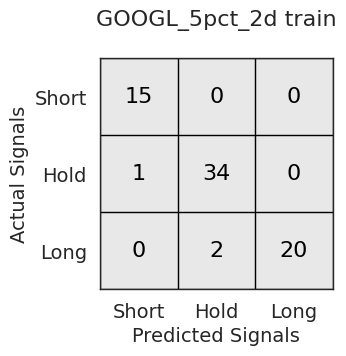

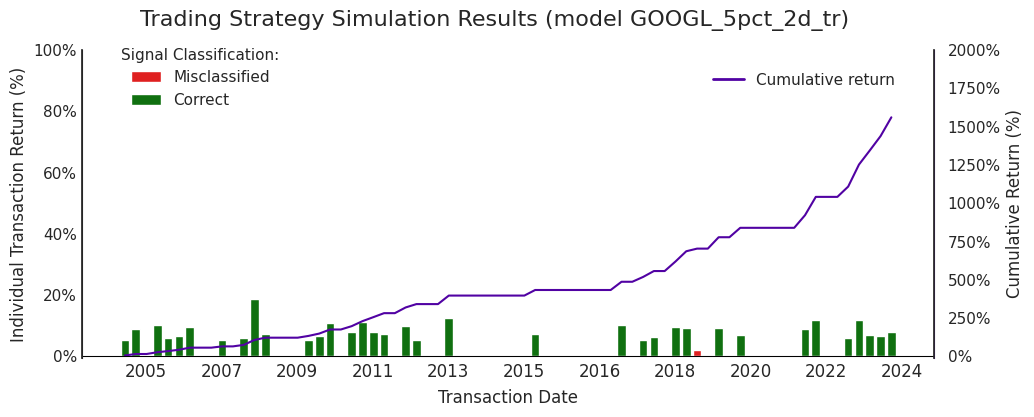

,GOOGL_5pct_2d_tr
metric,
Return window,2.00
Signal Threshold,0.05
Number of observations,72.00
Number of true trading signals (opportunities),37.00
Number of predicted trading signals,36.00
Number of predicted trading signals (2023 -2024),5.00
Number of profitable trades,36.00
Recall for trading signals (identified opportunities),0.95
Precision for traded signals (correctly classified),0.97


In [ ]:
# calculate evaluation metrics
df_train = df[df['dataset'] == 'train']
df_train = calculate_strategy_returns(df_train, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col=signal_col)

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_train, y_train_pred, "train", model_name)
plot_strategy_evaluation(df_train, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.005, 1), ax2_ylim=(-0.1, 20),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_tr)',
                         use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_train, model_name=f'{model_name}_tr', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -1:]

**Training Performance:**

- The training dataset demonstrates high weighted average precision for traded signals (Long  and Short), meaning that when the model predicts a trading signal, it is very likely to be correct.
- The confusion matrix confirms that most predicted trades align with actual signals with high precision
- The number of profitable trades (win rate) is strong.

**Interpretation:**
- The model’s high precision in training suggests that it effectively filters out weak signals, focusing only on high-confidence trades.
- However, this is expected in an in-sample environment, and further validation is required to assess its adaptability.

**Test**

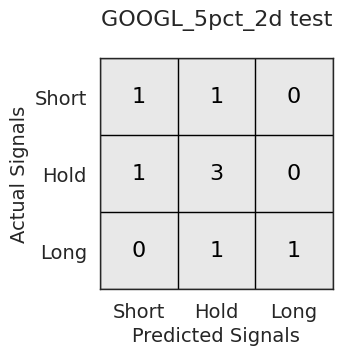

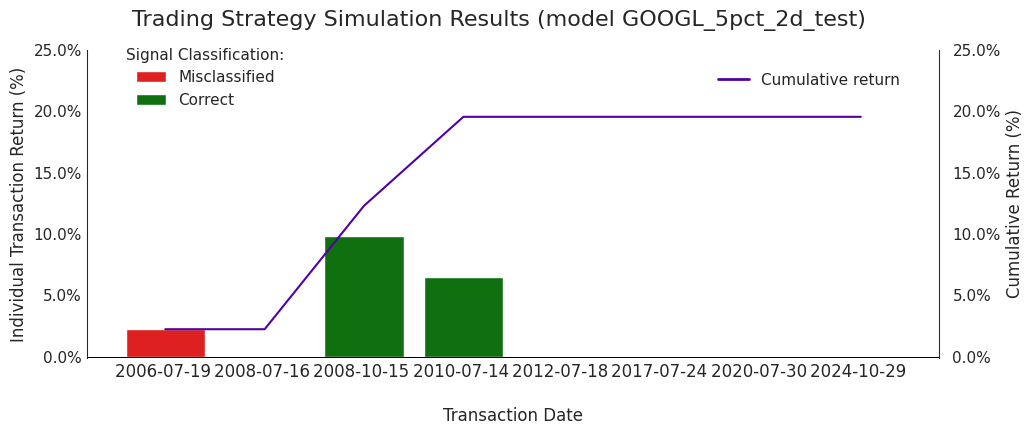

,GOOGL_5pct_2d_tr,GOOGL_5pct_2d_test
metric,,
Return window,2.00,2.00
Signal Threshold,0.05,0.05
Number of observations,72.00,8.00
Number of true trading signals (opportunities),37.00,4.00
Number of predicted trading signals,36.00,3.00
Number of predicted trading signals (2023 -2024),5.00,0.00
Number of profitable trades,36.00,3.00
Recall for trading signals (identified opportunities),0.95,0.50
Precision for traded signals (correctly classified),0.97,0.67


In [ ]:
# calculate strategy results
df_test = df[df['dataset'] == 'test']
df_test = calculate_strategy_returns(df_test, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_test, y_test_pred, "test", model_name)
plot_strategy_evaluation(df_test, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.001, 0.25), ax2_ylim=(-0.001, 0.25),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_test)',
                         use_datetime_labels=False)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_test, model_name=f'{model_name}_test',return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -2:]

**Test Performance:**

- Though the weighted average precision for traded signals (Long  and Short) is lower compared to training, it exceeds 50%, suggesting that the model retains predictive power beyond random chance.
- Misclassification does not result in a loss and the model achieves a 100% win rate with zero drawdown.
- The test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision


**Interpretation:**
- While precision drops in the test dataset, this should be interpreted cautiously due to the small number of test observations.
- A larger dataset would provide a clearer picture of whether this is a genuine issue with the model or just a reflection of the inherent randomness in a small sample size.

**Train & Test**

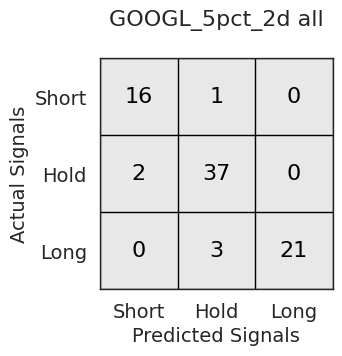

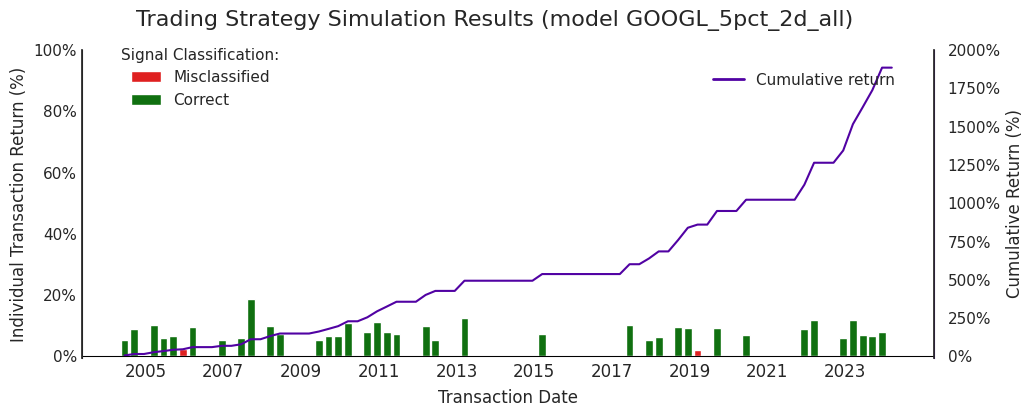

,GOOGL_5pct_2d_tr,GOOGL_5pct_2d_test,GOOGL_5pct_2d_all
metric,,,
Return window,2.00,2.00,2.00
Signal Threshold,0.05,0.05,0.05
Number of observations,72.00,8.00,80.00
Number of true trading signals (opportunities),37.00,4.00,41.00
Number of predicted trading signals,36.00,3.00,39.00
Number of predicted trading signals (2023 -2024),5.00,0.00,5.00
Number of profitable trades,36.00,3.00,39.00
Recall for trading signals (identified opportunities),0.95,0.50,0.90
Precision for traded signals (correctly classified),0.97,0.67,0.95


In [ ]:
# calculate strategy results
df_all = calculate_strategy_returns(df, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')
df_all.to_csv(f'df_export {model_name}.csv')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(df['signal'], df['signal_pred'], "all", model_name)
plot_strategy_evaluation(df_all, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.005, 1), ax2_ylim=(-0.1, 20),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_all)',
                         use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_all, model_name=f'{model_name}_all', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -3:]

**Full dataset performance:**

Although test results show some variability, the overall model demonstrates a strong ability to avoid false signals.

**Next steps:**
- More data would help confirm whether the observed drop in precision in the test set is a structural issue or just a sample size effect.
- Ensuring only relevant features are contributing to signals could further stabilise precision.
- Regular evaluation will help determine whether precision fluctuations are due to market conditions or model behaviour.
  

# 4. NVDA

## 4.1 NVDA model 1

### 4.1.1 Define variables & map the true signal & train test split

**Define variables and strategy**

**Initial Setup:** The strategy begins with 100% cash and dynamically opens positions based on generated trading signals.

**Trading Signals:** The model predicts trading signals based on expected equity returns:

- **Long Position (1):** A long trade is initiated when the expected return exceeds the long entry threshold (hold_max).
The position remains open for a predefined holding period.

- **Short Position (-1):** A short trade is triggered when the expected price decline surpasses the short entry threshold (hold_min).

- **Hold (0):** No position is opened if neither a long nor short signal is generated.

In [ ]:
# Traded Asset & Data Range
model_name_subset = ['NVDA']  # List of traded assets
start_date = '2005-01-01'  # Start date for data analysis
model_name = ', '.join(model_name_subset) + '_5pct_2d' # Define a reference name for the model

# Signal Thresholds for Execution
hold_min = -0.05  # Short position threshold
hold_max = 0.05   # Long position threshold

# Trading Signal Parameters
signal_col = 'signal_pred'  # Column containing predicted signals
traded_signals = [-1, 1]     # -1: Short, 1: Long

# Return parameters
return_col = 'returnPost_2d'  # Column for post-signal returns
return_window = 2            # Return calculation window in days

**Apply the constrains, review, and label the data**

In [ ]:
# subset the data and review
df = df_full.copy()
df = df[(df['symbol'].isin(model_name_subset)) & (df['date'] >= start_date)]
display(df.info()), display(desc_stat_summary(df))

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 880 to 915
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             36 non-null     datetime64[ns]
 1   month                            36 non-null     string        
 2   weekday                          36 non-null     string        
 3   symbol                           36 non-null     string        
 4   returnPre_2d                     36 non-null     float64       
 5   returnPre_5d                     36 non-null     float64       
 6   BOP_SMA_10d                      36 non-null     float64       
 7   BOP_SMA_15d                      36 non-null     float64       
 8   closeCV_10d                      36 non-null     float64       
 9   closeCV_15d                      36 non-null     float64       
 10  epsSurprise_pct                  36 non-null     float64       
 1

None

,count,mean,std,min,25%,50%,75%,max,Range,IQR,Skewness (n=0),Kurtosis (n=3),"Shapiro-Wilk, stat (n=1)","Shapiro-Wilk, p-value (>0.05)",Outliers (IQR),Outliers (Tukey),Outliers (Three-Sigma)
returnPre_2d,36.00,-0.00,0.03,-0.07,-0.02,-0.01,0.01,0.09,0.16,0.03,0.82,4.41,0.95,0.09,2,0,0
returnPre_5d,36.00,0.01,0.06,-0.10,-0.02,0.00,0.04,0.15,0.25,0.06,0.47,3.00,0.95,0.11,1,0,0
BOP_SMA_10d,36.00,0.05,0.13,-0.22,-0.04,0.07,0.15,0.35,0.57,0.20,0.07,2.50,0.99,0.94,0,0,0
BOP_SMA_15d,36.00,0.07,0.10,-0.09,-0.00,0.08,0.15,0.27,0.35,0.15,0.14,1.99,0.96,0.18,0,0,0
closeCV_10d,36.00,0.03,0.02,0.01,0.02,0.03,0.04,0.08,0.07,0.02,0.61,2.99,0.95,0.08,1,0,0
closeCV_15d,36.00,0.04,0.02,0.01,0.03,0.04,0.05,0.09,0.07,0.02,0.42,2.86,0.96,0.21,1,0,0
epsSurprise_pct,36.00,0.13,0.13,-0.17,0.07,0.10,0.18,0.47,0.64,0.11,0.45,3.75,0.95,0.07,4,0,0
epsSurpriseChange_QoQ,35.00,-0.00,0.13,-0.29,-0.06,-0.00,0.06,0.40,0.69,0.11,0.41,5.02,0.92,0.02,5,1,1
standEpsSurpriseScore,32.00,1.63,1.67,-2.40,0.52,1.70,2.51,6.66,9.07,1.99,0.19,4.64,0.94,0.07,1,0,1
revSurprise_pct,36.00,0.12,0.13,-0.05,0.04,0.08,0.16,0.52,0.57,0.13,1.48,4.74,0.85,0.00,3,0,1


(None, None)

In [ ]:
# generate the True labels
df['signal'] = df[return_col].apply(lambda x: 1 if x > hold_max else (-1 if x < hold_min else 0))
df['signal'].value_counts(), df['signal'].value_counts().sum()

(signal
  0    16
  1    14
 -1     6
 Name: count, dtype: int64,
 36)

**Define features and split the data into train/test sets**

Note: Stratified Sampling to maintain the class distribution in both sets.

In [ ]:
# subset y-variables and numeric features.
y_variables = ['returnPost_2d', 'returnPost_5d', 'signal']
num_features = df.select_dtypes(include=['number']).columns.difference(y_variables).tolist()
display(f'X-features list: {num_features}')

# Set the variables:
X = df[num_features]
y = df['signal']

# Create train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42)

# Add train/test mapping to the original dataset
df['dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'

"X-features list: ['BOP_SMA_10d', 'BOP_SMA_15d', 'CPI_pct_QoQ', 'FedDebt_pct_QoQ', 'RealGDP_pct_QoQ', 'USTYield_10y_bps_QoQ', 'USTYield_2y_bps_QoQ', 'USTYield_3m_bps_QoQ', 'USTYield_5y_bps_QoQ', 'UnemploymentRate_pct', 'Unemployment_bps_QoQ', 'closeCV_10d', 'closeCV_15d', 'currentRatio', 'debtToAssets', 'debtToAssets_YoY_bps', 'debtToEquity', 'debtToEquity_YoY_bps', 'dividendPayoutRatio_ttm', 'dividendPayoutRatio_ttm_YoY_bps', 'epsSurpriseChange_QoQ', 'epsSurprise_pct', 'netProfitMargin', 'netProfitMargin_YoY_bps', 'operatingCashFlow_qtly_YoY', 'pSalesRatio', 'peRatio', 'pre_macro_sentiment', 'pre_sentiment', 'returnOnAssets_ttm', 'returnOnAssets_ttm_YoY_bps', 'returnOnEquity_ttm', 'returnOnEquity_ttm_YoY_bps', 'returnPre_2d', 'returnPre_5d', 'revSurpriseChange_QoQ', 'revSurprise_pct', 'revenueAct_YoY', 'revenue_qtly_YoY', 'standEpsSurpriseScore', 'standRevSurpriseScore', 'totalAssets_YoY']"

### 4.1.2 Fit & evaluate the baseline model

**Fit the model**

In [ ]:
# Create the and fit baseline model.
rf1 = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=2,
                             max_depth = 6,
                             max_features='sqrt',
                             n_jobs=-1,
                             random_state=42)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

**View the Classification Report**

In [ ]:
# Print classification report of the preliminary random forest model
print(f"For train data in rf1 \n {classification_report(y_train, rf1.predict(X_train))}")
print(f"For test data in rf1 \n {classification_report(y_test, rf1.predict(X_test))}")

# Extract precision values
train_precision = extract_precision(classification_report(y_train, rf1.predict(X_train), output_dict=True))
test_precision = extract_precision(classification_report(y_test, rf1.predict(X_test), output_dict=True))

# Create DataFrame
data = {'Dataset': [f'rf1_Train {model_name}', f'rf1_Test {model_name}'],
        'Short': [train_precision['-1'], test_precision['-1']],
        'Hold': [train_precision['0'], test_precision['0']],
        'Long': [train_precision['1'], test_precision['1']],
        'wtAvg': [train_precision['weighted avg'], test_precision['weighted avg']]}

rf1_precision_df = pd.DataFrame(data)

summary_precision_df = rf1_precision_df.copy()

# Display precision from the classification report
summary_precision_df

For train data in rf1 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00         5
           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

For test data in rf1 
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4



,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train NVDA_5pct_2d,1.00,1.00,1.00,1.00
1,rf1_Test NVDA_5pct_2d,0.00,0.67,1.00,0.58


**Model performance evaluation:**

1) The baseline model overfits, achieving 100% accuracy across all metrics. This suggests that it has memorised the training data
2) However, precision and recall for the test dataset exceed 50% for both -1 (Short) and 1 (Long), suggesting that the model retains some predictive power beyond random chance..

### 4.1.3 Hyperparameter Tuning, fit & evaluate the final Model

**Hyperparameter tuning approach:**

To optimise model performance, we apply RandomizedSearchCV for hyperparameter tuning.

Our primary objective is to minimise loss-making trades, even at the expense of missing some profitable opportunities. Since false positives for labels 1 (Buy) and -1 (Sell) can lead to significant costs, we focus on reducing incorrect trade executions. Consequently, we optimise for precision, ensuring that only high-confidence signals are acted upon. We use scoring='precision_weighted' to guide model optimisation, prioritising the reduction of misclassified trades.

The hyperparameter grid is designed considering the dataset size, class distribution, and the key evaluation metrics outlined above.


**Tuning Strategy**

- Search Method: RandomizedSearchCV (Efficient sampling across hyperparameters)
- Number of Iterations: n_iter=50 (Balances thorough exploration with computational efficiency)
- Cross-Validation: cv=10 (Ensures model generalisation across different data splits)
- Scoring Metric: precision_weighted (Prioritises avoiding incorrect buy/sell signals to minimise losses)
- Parallel Processing: n_jobs=-1 (Leverages all available cores for faster execution)



**Hyperparameter Grid & Rationale**

**n_estimators**: Number of trees in the ensemble
- Values: randint(50, 200)
- Rationale: A moderate range ensures sufficient model complexity while avoiding excessive overfitting or computation costs.

**max_depth**: Maximum depth of each tree
- Values: [3, 5, 7, None]
- Rationale: Controlling tree depth reduces the risk of overfitting, while None allows flexibility if deeper trees prove beneficial.

**min_samples_split**: Minimum samples required to split an internal node
- Values: randint(5, 15)
- Rationale: Higher thresholds prevent overfitting to small, noise-driven patterns, enforcing broader, more general decision rules.

**min_samples_leaf**: Minimum samples required at a leaf node
- Values: randint(2, 6)
- Rationale: Increasing the minimum leaf size reduces sensitivity to outliers and avoids making overly aggressive trading decisions based on limited data points.

**max_features**: Number of features considered at each split
- Values: ['sqrt', 'log2', None]
- Rationale: Randomly selecting features per split helps prevent over-reliance on specific indicators and improves generalisability.



In [ ]:
# Define hyperparameter distribution for tuning
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 7, None],
    'min_samples_split': randint(5, 15),
    'min_samples_leaf': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
}

# Initialise and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='precision_weighted',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Output the best combination of hyperparameters found
print("Best parameters:", random_search.best_params_)

# Use best parameters to fit final model
rfBest = RandomForestClassifier(**random_search.best_params_,
                                n_jobs=-1,
                                random_state=42)
rfBest.fit(X_train, y_train)

# Assign variables to predicted signals
y_test_pred = rfBest.predict(X_test)
y_train_pred = rfBest.predict(X_train)
y_pred = rfBest.predict(X)

# Update the dataset with predicted signals
df['signal_pred'] = y_pred

Best parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 192}


**Classification Report**

In [ ]:
# Print classification report of the Randomised Search random forest model
print(f"For train data in rfBest {model_name} \n {classification_report(y_train, rfBest.predict(X_train))}")
print(f"For test data in rfBest {model_name}\n {classification_report(y_test, rfBest.predict(X_test))}")
#print(f"For all data in rfBest {model_name} \n {classification_report(df['signal'], df['signal_pred'])}")

# Extract precision values
train_precision_best = extract_precision(classification_report(y_train, rfBest.predict(X_train), output_dict=True))
test_precision_best = extract_precision(classification_report(y_test, rfBest.predict(X_test), output_dict=True))

# Create DataFrame
data_best = {
    'Dataset': [f'rfBest_Train {model_name}', f'rfBest_Test {model_name}'],
    'Short': [train_precision_best['-1'], test_precision_best['-1']],
    'Hold': [train_precision_best['0'], test_precision_best['0']],
    'Long': [train_precision_best['1'], test_precision_best['1']],
    'wtAvg': [train_precision_best['weighted avg'], test_precision_best['weighted avg']]
}

rfBest_precision_df = pd.DataFrame(data_best)

summary_precision_df = pd.concat([summary_precision_df, rfBest_precision_df], ignore_index=True)
summary_precision_df.to_csv(f'summary_precision_{model_name}.csv', index=False)
print('Precision summary:')
summary_precision_df

For train data in rfBest NVDA_5pct_2d 
               precision    recall  f1-score   support

          -1       1.00      0.40      0.57         5
           0       0.93      1.00      0.97        14
           1       0.87      1.00      0.93        13

    accuracy                           0.91        32
   macro avg       0.93      0.80      0.82        32
weighted avg       0.92      0.91      0.89        32

For test data in rfBest NVDA_5pct_2d
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4

Precision summary:


,Dataset,Short,Hold,Long,wtAvg
0,rf1_Train NVDA_5pct_2d,1.00,1.00,1.00,1.00
1,rf1_Test NVDA_5pct_2d,0.00,0.67,1.00,0.58
2,rfBest_Train NVDA_5pct_2d,1.00,0.93,0.87,0.92
3,rfBest_Test NVDA_5pct_2d,0.00,0.67,1.00,0.58


**Model performance evaluation:**

1. The tuned model (rf_best) shows a slight reduction in training accuracy, which is a positive sign as it suggests the model has generalised better.
2. Test weighted average precision is decent. Class precision for both -1 (Short) and 1 (Long) demonstrably exceeds 50% suggesting that the model has predictive power.  However, we note that the test dataset is small, meaning that even a few misclassified trades can significantly impact the observed precision.

**Feature Importances**

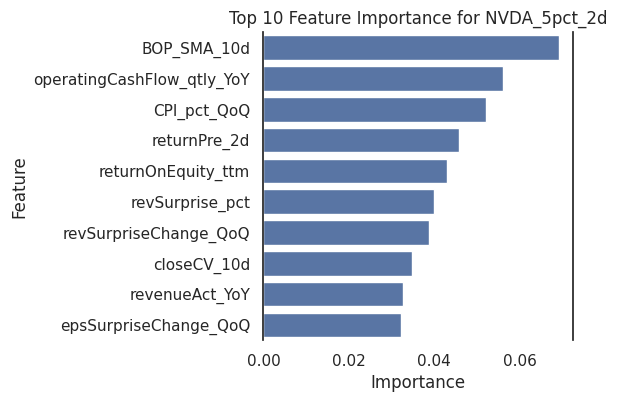

In [ ]:
# Get feature importances from the trained RandomForestClassifier
rfBest_feat_imp = rfBest.feature_importances_

# Create a DataFrame to display feature importances
rfBest_feat_imp_df = pd.DataFrame({'Feature': num_features, 'Importance': rfBest_feat_imp})

# Sort the DataFrame by importance in descending order
rfBest_feat_imp_df = rfBest_feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot top 10 features of rfBest
title = f'Top 10 Feature Importance for {model_name}'
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=rfBest_feat_imp_df.head(10))
plt.title(title)
plt.xlabel('Importance')
plt.ylabel('Feature')
filename = f"{title.replace(' ', '_')}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

**Feature Importance Analysis and Model Considerations**

Ensemble models, by design, do not provide direct insight into how each feature influences predictions. However, analysing **feature importance rankings** offers valuable insights into the model’s decision-making process.

Many of the **top-ranked features align well with industry knowledge**, indicating that the model is capturing meaningful patterns. However, some features appear highly ranked despite being expected to have low to moderate influence on trading decisions based on fundamental reasoning.

This discrepancy suggests that the model may be detecting **spurious statistical patterns** rather than genuine predictive relationships. While these features might improve short-term accuracy, they do not necessarily provide real predictive value and could compromise the model’s stability over time.

The presence of potentially misleading features highlights the need for **continuous evaluation, periodic recalibration, and refinement** of the feature set. **Frequent reassessment** helps ensure that the model remains robust and does not overfit to patterns that arise purely by chance.

**Next Steps**
- **Feature Selection & Refinement**: Removing irrelevant or misleading features may enhance long-term model stability and performance.
- **Regular Model Audits**: Monitoring feature importance over time to detect shifts in predictive value.
- **Recalibration Strategy**: Adjusting the model at regular intervals to prevent overfitting to short-term patterns.

Refining the feature set should be a priority, as it can lead to a more resilient and interpretable model while maintaining strong predictive power.

### 4.1.4 Evaluate the strategy

**Train**

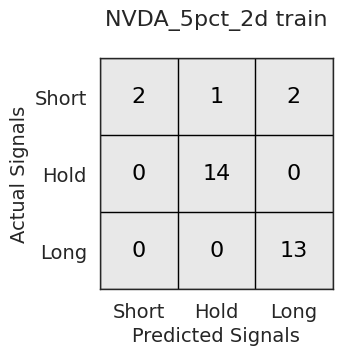

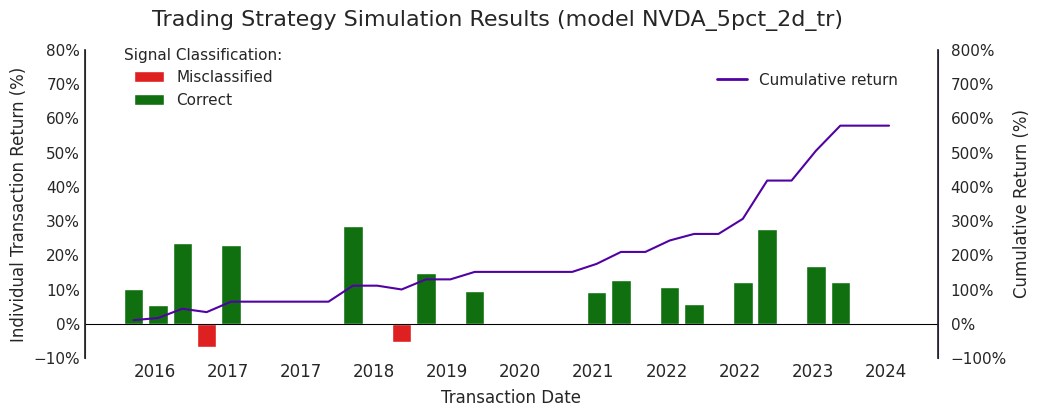

,NVDA_5pct_2d_tr
metric,
Return window,2.00
Signal Threshold,0.05
Number of observations,32.00
Number of true trading signals (opportunities),18.00
Number of predicted trading signals,17.00
Number of predicted trading signals (2023 -2024),4.00
Number of profitable trades,15.00
Recall for trading signals (identified opportunities),0.83
Precision for traded signals (correctly classified),0.88


In [ ]:
# calculate evaluation metrics
df_train = df[df['dataset'] == 'train']
df_train = calculate_strategy_returns(df_train, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col=signal_col)

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_train, y_train_pred, "train", model_name)
plot_strategy_evaluation(df_train, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.1, 0.8), ax2_ylim=(-1, 8),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_tr)',
                         use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_train, model_name=f'{model_name}_tr', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -1:]

**Training Performance:**

- The training dataset demonstrates high weighted average precision for traded signals (Long  and Short), meaning that when the model predicts a trading signal, it is very likely to be correct.
- The confusion matrix confirms that most predicted trades align with actual signals with high precision
- The number of profitable trades (win rate) is strong.

**Interpretation:**
- The model’s high precision in training suggests that it effectively filters out weak signals, focusing only on high-confidence trades.
- However, this is expected in an in-sample environment, and further validation is required to assess its adaptability.

**Test**

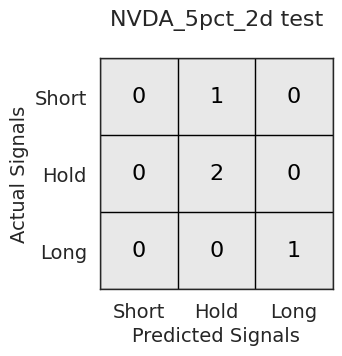

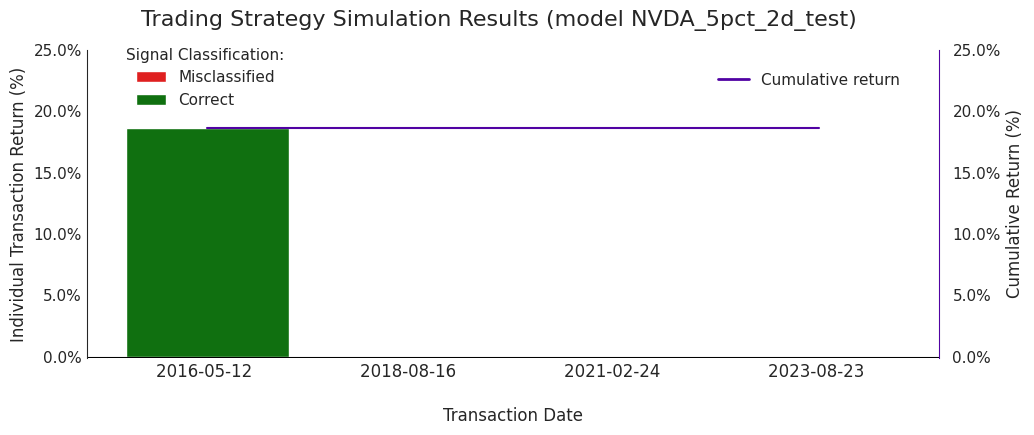

,NVDA_5pct_2d_tr,NVDA_5pct_2d_test
metric,,
Return window,2.00,2.00
Signal Threshold,0.05,0.05
Number of observations,32.00,4.00
Number of true trading signals (opportunities),18.00,2.00
Number of predicted trading signals,17.00,1.00
Number of predicted trading signals (2023 -2024),4.00,0.00
Number of profitable trades,15.00,1.00
Recall for trading signals (identified opportunities),0.83,0.50
Precision for traded signals (correctly classified),0.88,1.00


In [ ]:
# calculate strategy results
df_test = df[df['dataset'] == 'test']
df_test = calculate_strategy_returns(df_test, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(y_test, y_test_pred, "test", model_name)
plot_strategy_evaluation(df_test, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.001, 0.25), ax2_ylim=(-0.001, 0.25),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_test)',
                         use_datetime_labels=False)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_test, model_name=f'{model_name}_test',return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -2:]

**Test Performance:**

- The model exhibits high precision, even surpassing performance on the training dataset.
- The confusion matrix reveals that 3 out of 4 signals align with actual signals, with only one misclassification. Given the nature of the misclassification (a True Short signal being classified as Hold, thereby preventing a transaction), the impact on strategy performance is negligible, resulting in zero P&L effect with 100% precision and win rate.

**Interpretation:**
- While precision improves in the test dataset, this should be interpreted cautiously due to the small number of test observations.
- A larger dataset would provide a clearer picture of whether this is a genuine issue with the model or just a reflection of the inherent randomness in a small sample size.

**Train & Test**

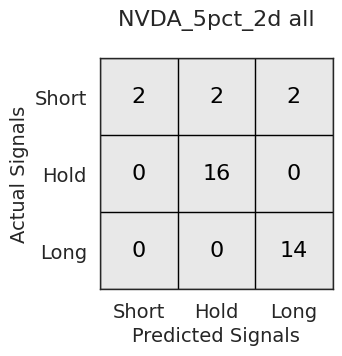

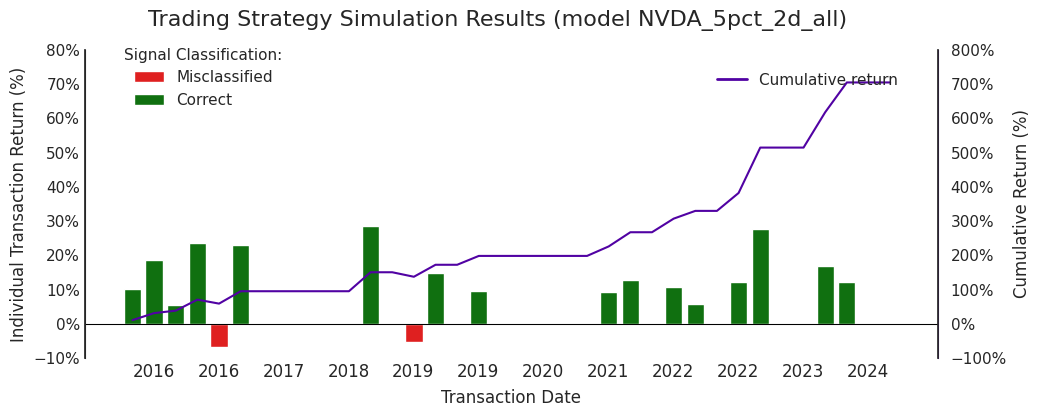

,NVDA_5pct_2d_tr,NVDA_5pct_2d_test,NVDA_5pct_2d_all
metric,,,
Return window,2.00,2.00,2.00
Signal Threshold,0.05,0.05,0.05
Number of observations,32.00,4.00,36.00
Number of true trading signals (opportunities),18.00,2.00,20.00
Number of predicted trading signals,17.00,1.00,18.00
Number of predicted trading signals (2023 -2024),4.00,0.00,4.00
Number of profitable trades,15.00,1.00,16.00
Recall for trading signals (identified opportunities),0.83,0.50,0.80
Precision for traded signals (correctly classified),0.88,1.00,0.89


In [ ]:
# calculate strategy results
df_all = calculate_strategy_returns(df, traded_signals=traded_signals, hold_days=return_window, return_col=return_col, signal_col='signal_pred')
df_all.to_csv(f'df_export {model_name}.csv')

# plot the strategy simulation results & confusion matrix
plot_confusion_matrix(df['signal'], df['signal_pred'], "all", model_name)
plot_strategy_evaluation(df_all, signal_col='signal_pred', traded_signals=tuple(traded_signals),
                         ax1_ylim=(-0.1, 0.8), ax2_ylim=(-1, 8),
                         x_label_rotation=0, x_label_fontsize=12,
                         plot_name=f'Trading Strategy Simulation Results (model {model_name}_all)',
                         use_datetime_labels=True)

# update and print model_evaluation_summary
model_evaluation_summary = model_eval_summary(df=df_all, model_name=f'{model_name}_all', return_window=return_window, traded_signals=traded_signals)
model_evaluation_summary.iloc[:, -3:]

**Full dataset performance:**

The overall model demonstrates a strong ability to avoid false signals.

**Next steps:**
- While model demonstrates high precision both in the test and train datasets, this should be interpreted cautiously due to the small number of observations.
- A larger dataset would provide a clearer picture of whether this is a genuine issue with the model or just a reflection of the inherent randomness in a small sample size.
- Ensuring only relevant features are contributing to signals could further stabilise precision.
- Regular evaluation will help determine whether precision fluctuations are due to market conditions or model behaviour.

# 5. Final model & strategy evaluation summary  

In [ ]:
model_evaluation_summary.to_csv('model_evaluation_summary.csv')
model_evaluation_summary.style \
    .set_table_styles([{'selector': 'th, td', 'props': [('font-size', '10px')]}]) \
    .set_properties(**{'text-align': 'center'}) \
    .format(precision=2)

,GOOGL_5pct_2d_tr,GOOGL_5pct_2d_test,GOOGL_5pct_2d_all,AAPL_5pct_2d_tr,AAPL_5pct_2d_test,AAPL_5pct_2d_all,AAPL_4pct_2d_tr,AAPL_4pct_2d_test,AAPL_4pct_2d_all,AAPL_5pct_5d_tr,AAPL_5pct_5d_test,AAPL_5pct_5d_all,NVDA_5pct_2d_tr,NVDA_5pct_2d_test,NVDA_5pct_2d_all
metric,,,,,,,,,,,,,,,
Return window,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,5.00,5.00,5.00,2.00,2.00,2.00
Signal Threshold,0.05,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.05,0.05,0.05,0.05,0.05,0.05
Number of observations,72.00,8.00,80.00,72.00,9.00,81.00,72.00,9.00,81.00,72.00,9.00,81.00,32.00,4.00,36.00
Number of true trading signals (opportunities),37.00,4.00,41.00,33.00,4.00,37.00,44.00,5.00,49.00,44.00,5.00,49.00,18.00,2.00,20.00
Number of predicted trading signals,36.00,3.00,39.00,21.00,2.00,23.00,42.00,5.00,47.00,45.00,6.00,51.00,17.00,1.00,18.00
Number of predicted trading signals (2023 -2024),5.00,0.00,5.00,0.00,0.00,0.00,3.00,0.00,3.00,3.00,0.00,3.00,4.00,0.00,4.00
Number of profitable trades,36.00,3.00,39.00,19.00,2.00,21.00,40.00,2.00,42.00,41.00,3.00,44.00,15.00,1.00,16.00
Recall for trading signals (identified opportunities),0.95,0.50,0.90,0.58,0.50,0.57,0.89,0.40,0.84,0.89,0.60,0.86,0.83,0.50,0.80
Precision for traded signals (correctly classified),0.97,0.67,0.95,0.90,1.00,0.91,0.93,0.40,0.87,0.87,0.50,0.82,0.88,1.00,0.89


**Key Takeaways**


**Summary:**

Among the models, GOOGL demonstrates the best balance between predictive power and risk management, while NVDA shows promise but requires further validation. AAPL’s model needs refinement to improve precision and reduce test variability.


**Test Performance:**

- AAPL’s precision on test data is weak (~50%), suggesting potential robustness issues.

- GOOGL maintains predictive power with a 100% win rate and no drawdown.

- NVDA demonstrates the highest test precision but requires further validation due to the small sample size.


**Trading Strategy Impact:**

- GOOGL’s tuned model is the most stable, avoiding drawdowns while maintaining precision.

- NVDA exhibits strong test performance, but a larger dataset is needed for confirmation.

- AAPL’s tuned model reduces false positives but still faces generalisation challenges.


**Important notice:**

1) Feature Importance & Model Interpretation: Ensemble models like DecissionTreeClassifyer do not offer direct interpretability, but feature importance rankings provide insight into decision-making. Most of the features identified as significant align with industry knowledge, indicating that the model captures meaningful patterns. Some features rank highly despite their expected low to moderate relevance, suggesting potential detection of spurious patterns. Such patterns may enhance short-term accuracy but risk reducing model stability over time.

2) Given the small test dataset, results should be interpreted cautiously. Model performance may vary due to data limitations, requiring ongoing monitoring and additional testing with newly accumulated data before drawing definitive conclusions.

**Next Steps:**

- Feature Selection & Optimization: Remove irrelevant or misleading features to improve model robustness.
- Ongoing Model Evaluation & Adjustment: Track changes in feature importance to detect and mitigate overfitting.
- Development & Implementation of Stop-Loss Rules: Design measures to enhance strategy profitability.
- Model Testing on Ticker Data: Validate performance using real market data.